<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/07_GNN_SchNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SchNet: 3D-aware Neural Networks for Quantum Chemistry

## Table of Contents
0. [Setup and Installation](#setup-and-installation)
1. [Introduction to SchNet](#introduction)
2. [Theoretical Background: 3D-aware Neural Networks](#theoretical-background)
3. [SchNet Architecture in Detail](#schnet-architecture)
4. [Visualizing SchNet Operations](#visualization)
5. [Implementing SchNet for Property Prediction](#implementation)
6. [Visualizing Learned Molecular Representations](#visualize-learned-representation)
7. [Applications and Future Directions](#applications)
8. [Conclusion](#conclusion)

## 0. Setup and Installation <a name="setup-and-installation"></a>

First, let's install the necessary libraries for working with SchNet. We'll need PyTorch, PyTorch Geometric, RDKit for molecular processing, and visualization tools.

In [1]:
#@title Install required packages
import os
import sys
import torch
os.environ['TORCH'] = torch.__version__
print(f"PyTorch version: {torch.__version__}")

# Install PyTorch Geometric and related packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Install visualization and molecular tools
!pip install -q rdkit
!pip install -q plotly

PyTorch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 51.0 MB/s eta 0:00:00


In [12]:
#@title Import required libraries
import os
import torch
import numpy as np
from typing import Tuple, List, Dict, Optional
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import SchNet
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader



# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Optional: Set precision for better numerical stability
torch.set_float32_matmul_precision('high')

Using device: cuda


## 1. Introduction to SchNet <a name="introduction"></a>

### What is SchNet?

SchNet is a deep learning architecture specifically designed for modeling quantum interactions in molecules and materials. Introduced by Schütt et al. in 2017, SchNet extends the capabilities of traditional Graph Neural Networks (GNNs) by incorporating 3D spatial information through continuous-filter convolutional layers.

### Why 3D Information Matters in Molecular Modeling

While traditional GNNs like Graph Convolutional Networks (GCNs) work well for 2D molecular graphs, they have a significant limitation: they don't account for the 3D spatial arrangement of atoms, which is crucial for many molecular properties.

Consider these key differences:

| Traditional GNNs (e.g., GCN) | 3D-aware GNNs (e.g., SchNet) |
|------------------------------|-------------------------------|
| Work with 2D molecular graphs | Consider 3D atomic coordinates |
| Only model bonds as binary connections | Model distance-dependent interactions |
| Cannot distinguish different conformers | Can differentiate molecular conformations |
| Limited for quantum chemistry applications | Suitable for quantum property prediction |

### Key Innovations of SchNet

1. **Continuous-Filter Convolutions**: Unlike discrete grid-based convolutions, SchNet uses continuous filters that can operate on atoms at arbitrary positions in 3D space.

2. **Distance-based Interactions**: SchNet models interactions between atoms based on their interatomic distances, using a set of radial basis functions to provide a rich representation of spatial relationships.


3. **Physics-Informed Design**: SchNet respects fundamental quantum-chemical principles, including:
   - Rotational invariance for energy predictions
   - Translational invariance
   - Energy conservation for force predictions

4. **End-to-End Learning**: SchNet learns representations directly from atomic positions and types, without requiring predefined molecular descriptors or fingerprints.

5. **Versatility**: Can predict various molecular properties, including energies, forces, dipole moments, and more.

SchNet is particularly well-suited for predicting quantum-mechanical properties of molecules such as:

 - **Energies**: Total energy, atomization energy, formation energy
 - **Forces**: Interatomic forces for molecular dynamics simulations
 - **Electronic Properties**: HOMO-LUMO gap, dipole moments
 - **Atomic Properties**: Partial charges, atomic energies

These properties are essential for applications in drug discovery, materials science, and computational chemistry.

## 2. Theoretical Background: 3D-aware Neural Networks <a name="theoretical-background"></a>

### The Challenge of 3D Molecular Data

Molecules exist in 3D space, and their properties are heavily influenced by their spatial configuration. However, typical convolutional neural networks (CNNs) are designed for data on regular grids (like images). Molecular data presents several challenges:

1. **Irregular Spatial Structure**: Atoms can be located anywhere in 3D space, not on a grid
2. **Invariances**: Molecular properties should be invariant to translation and rotation
3. **Equivariances**: Some properties (like forces) should transform predictably with the molecule

### From CNNs to Continuous-Filter Convolutions

Standard 2D CNNs apply discrete filters to data on a grid:

$$(f * k)(x) = \sum_{y \in \Omega} f(y) \cdot k(x - y)$$

Where $f$ is the input, $k$ is the filter, and $\Omega$ is the grid.

SchNet generalizes this to continuous filters that can operate on atoms at arbitrary positions:

$$(f * k)(x) = \int_{\Omega} f(y) \cdot k(x - y) dy$$

In practice, this is implemented as:

$$x_i' = \sum_{j \in \mathcal{N}(i)} x_j \odot W(r_{ij})$$

Where:
- $x_i$ is the feature vector of atom $i$
- $\mathcal{N}(i)$ are the neighbors of atom $i$
- $r_{ij}$ is the distance between atoms $i$ and $j$
- $W(r_{ij})$ is a filter generated based on the distance
- $\odot$ represents element-wise multiplication

### Achieving Physical Invariances

To ensure SchNet respects physical laws:

1. **Rotational Invariance**: Using only distances between atoms (not absolute positions)
2. **Translational Invariance**: Working with relative positions rather than absolute coordinates
3. **Permutation Invariance**: Treating the molecule as a set of atoms, regardless of ordering

Let's visualize how these continuous filters work compared to standard CNNs:

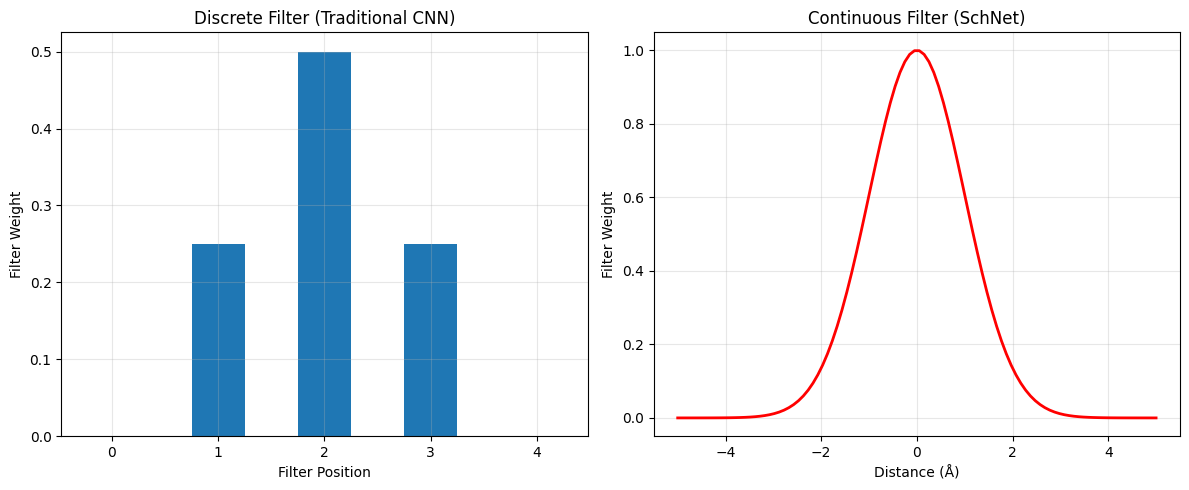

In [2]:
# Visualize the difference between discrete and continuous filters

def discrete_filter(x: np.ndarray, filter_width: int = 5) -> np.ndarray:
    """Creates a simple discrete filter with a peak in the center and smaller values on sides.
    
    Args:
        x: Input array of positions
        filter_width: Width of the filter kernel (odd number)
    
    Returns:
        np.ndarray: Filter values with peak in center and smaller values on sides
    """
    filter_values = np.zeros(filter_width)
    center = filter_width // 2
    filter_values[center] = 0.5  # Center peak
    filter_values[center-1] = 0.25  # Left side
    filter_values[center+1] = 0.25  # Right side
    return filter_values

def continuous_filter(x: np.ndarray, sigma: float = 1.0) -> np.ndarray:
    """Creates a continuous Gaussian filter.
    
    Args:
        x: Input array of positions
        sigma: Standard deviation controlling width of Gaussian
    
    Returns:
        np.ndarray: Gaussian filter values
    """
    return np.exp(-(x**2) / (2 * sigma**2))

# Create x values for plotting
x_discrete = np.arange(5)  # 5 discrete points
x_continuous = np.linspace(-5, 5, 100)  # 100 points for smooth curve

# Create filters
discrete_f = discrete_filter(x_discrete)
continuous_f = continuous_filter(x_continuous)

# Set up the visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot discrete filter (left subplot)
axes[0].bar(x_discrete, discrete_f, width=0.5)
axes[0].set_title('Discrete Filter (Traditional CNN)')
axes[0].set_xlabel('Filter Position')
axes[0].set_ylabel('Filter Weight')
axes[0].grid(True, alpha=0.3)

# Plot continuous filter (right subplot)
axes[1].plot(x_continuous, continuous_f, 'r-', linewidth=2)
axes[1].set_title('Continuous Filter (SchNet)')
axes[1].set_xlabel('Distance (Å)')
axes[1].set_ylabel('Filter Weight')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize a 3D continuous filter
# Create a 3D grid for visualization
x = np.linspace(-5, 5, 20)  # 20 points in each dimension
y = np.linspace(-5, 5, 20)
z = np.linspace(-5, 5, 20)
X, Y, Z = np.meshgrid(x, y, z)

# Calculate radial distances from origin
R = np.sqrt(X**2 + Y**2 + Z**2)

# Compute 3D Gaussian filter values
sigma = 2.0  # Controls spread of Gaussian
Filter_3D = np.exp(-(R**2) / (2 * sigma**2))

# Create interactive 3D visualization using Plotly
fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=Filter_3D.flatten(),
    isomin=0.1,  # Minimum threshold for isosurface
    isomax=0.8,  # Maximum threshold for isosurface
    surface_count=5,  # Number of isosurfaces to display
    colorscale='Viridis',
    opacity=0.6,
    caps=dict(x_show=False, y_show=False, z_show=False)  # Hide end caps
))

# Configure the layout
fig.update_layout(
    title='3D Continuous Filter for Molecular Interactions',
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)', 
        zaxis_title='Z (Å)'
    ),
    width=700,
    height=700,
    margin=dict(t=50, b=10, l=10, r=10)
)

fig.show()

## 3. SchNet Architecture in Detail <a name="schnet-architecture"></a>

SchNet is an end-to-end neural network architecture that learns representations of atoms in molecules based on continuous-filter convolutions. Let's break down its components:

### Overall Architecture

The SchNet architecture consists of three main components:

1. **Atom Embedding**: Maps each atom type to a feature vector
2. **Interaction Blocks**: Learn representations of atoms in their chemical environment
3. **Radial Basis Functions**: Transform interatomic distances into feature vectors
4. **Continuous-filter Convolution**: Applies filters based on interatomic distances
5. **Cutoff Function**: Limits interactions to a local chemical environment
6. **Output Blocks**: Transform atom-wise features to molecular properties


### Key Components

#### 1. Atom Embedding
- Each atom type (C, H, O, N, etc.) is embedded as a learnable vector
- The initial representation only depends on the element type

#### 2. Interaction Blocks
- Series of interaction layers that update atom representations based on their neighbors
- Each block contains:
  - **Continuous-Filter Convolution**: Applies distance-dependent filters to neighboring atoms
  - **Filter-Generating Network**: Creates filters based on interatomic distances
  - **Cutoff Function**: Limits interactions to a local chemical environment

#### 3. Output Networks
- Atom-wise layers transform features to atom-wise properties
- Pooling operations (e.g., sum or mean) aggregate atom features for molecule-level predictions

The core operation in SchNet is the continuous-filter convolution. For each atom $i$, the update rule is:

$$\mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \odot h_{\mathbf{\Theta}} ( \exp(-\gamma(\mathbf{e}_{j,i} - \mathbf{\mu})))$$

Where:
- $\mathbf{x}_j$ are the features of atom $j$
- $\mathcal{N}(i)$ is the neighborhood of atom $i$
- $\mathbf{e}_{j,i}$ is the distance between atoms $j$ and $i$
- $h_{\mathbf{\Theta}}$ is a neural network that generates filter weights
- $\odot$ denotes element-wise multiplication
- $\gamma$ and $\mathbf{\mu}$ are learned parameters


Let's implement a simplified version of the SchNet architecture to understand its key components:

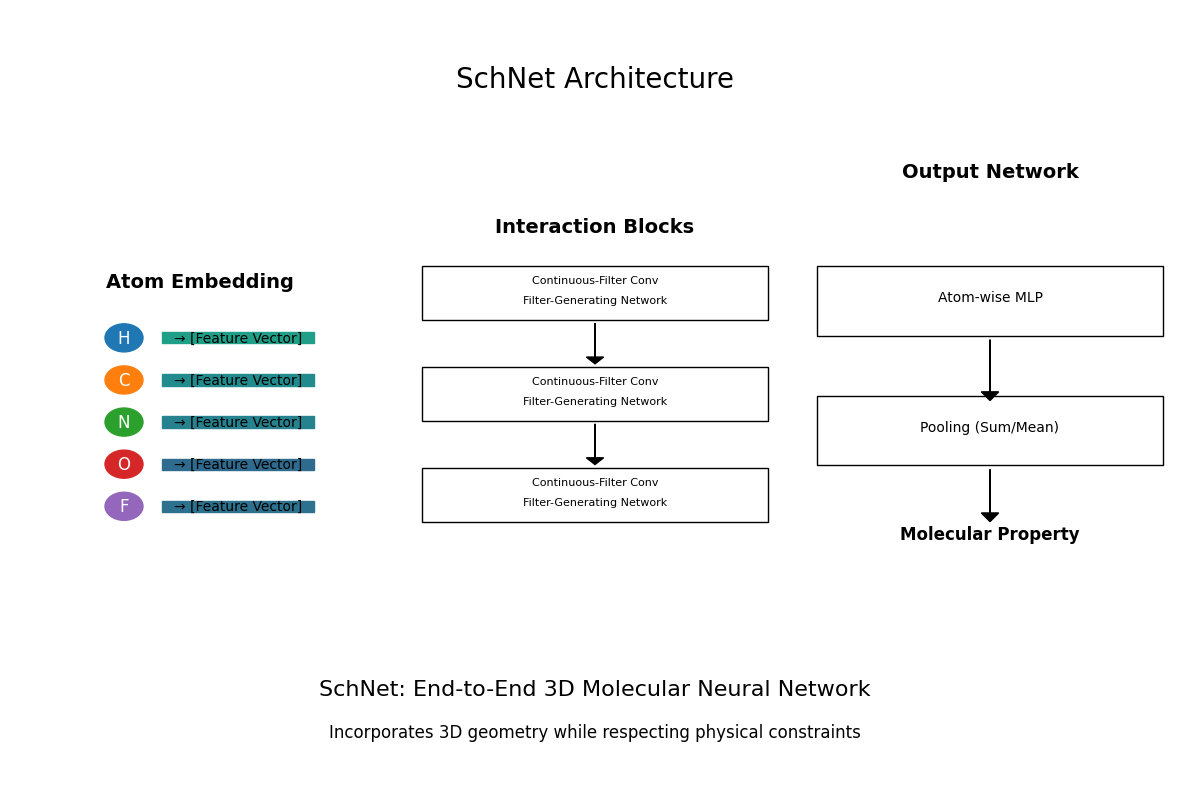

In [3]:
class ShiftedSoftplus(nn.Module):
    """
    Shifted softplus activation function: f(x) = ln(1 + e^x) - ln(2)
    Used in SchNet to ensure f(0) = 0
    """
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = np.log(2.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.softplus(x) - self.shift


class GaussianSmearing(nn.Module):
    """
    Gaussian smearing of distances to create distance features.
    
    Args:
        start (float): Starting value for Gaussian centers
        stop (float): Ending value for Gaussian centers  
        n_gaussians (int): Number of Gaussian functions to use
    """
    def __init__(self, start: float = 0.0, stop: float = 5.0, n_gaussians: int = 50):
        super(GaussianSmearing, self).__init__()
        offset = torch.linspace(start, stop, n_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist: torch.Tensor) -> torch.Tensor:
        """
        Expands distances using Gaussian basis functions
        
        Args:
            dist: Tensor of interatomic distances
            
        Returns:
            Tensor of expanded distance features
        """
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))


class CFConvSimplified(nn.Module):
    """
    Simplified continuous-filter convolution layer for SchNet.
    
    Args:
        n_features (int): Number of features per atom
        n_filters (int): Number of filters in the filter-generating network
    """
    def __init__(self, n_features: int, n_filters: int = 128):
        super(CFConvSimplified, self).__init__()
        # Filter-generating network
        self.filter_network = nn.Sequential(
            nn.Linear(n_filters, n_features),
            ShiftedSoftplus(),
            nn.Linear(n_features, n_features)
        )

        # Atom-wise layers
        self.conv_layers = nn.Sequential(
            nn.Linear(n_features, n_features),
            ShiftedSoftplus(),
            nn.Linear(n_features, n_features)
        )

    def forward(self, x: torch.Tensor, dist_expansion: torch.Tensor, neighbors: torch.Tensor) -> torch.Tensor:
        """
        Performs continuous-filter convolution
        
        Args:
            x: Atom feature vectors
            dist_expansion: Expanded distance features
            neighbors: Indices of neighboring atoms
            
        Returns:
            Updated atom features after convolution
        """
        # Generate filters from distance expansion
        W = self.filter_network(dist_expansion)  # [n_edges, n_features]

        # Get features of neighboring atoms
        neighbor_features = x[neighbors]  # [n_edges, n_features]

        # Apply filter
        neighbor_features = neighbor_features * W  # Element-wise multiplication

        # Aggregate messages from neighbors (simplified)
        aggregated = torch.zeros_like(x)
        for i in range(x.shape[0]):
            mask = neighbors == i
            if mask.any():
                aggregated[i] = neighbor_features[mask].sum(dim=0)

        # Apply atom-wise layers
        return self.conv_layers(aggregated)


class InteractionBlockSimplified(nn.Module):
    """
    Simplified SchNet interaction block.
    
    Args:
        n_features (int): Number of features per atom
        n_filters (int): Number of filters in CFConv layer
    """
    def __init__(self, n_features: int, n_filters: int = 128):
        super(InteractionBlockSimplified, self).__init__()
        self.cfconv = CFConvSimplified(n_features, n_filters)
        self.dense = nn.Linear(n_features, n_features)
        self.activation = ShiftedSoftplus()

    def forward(self, x: torch.Tensor, dist_expansion: torch.Tensor, neighbors: torch.Tensor) -> torch.Tensor:
        """
        Performs one interaction block pass
        
        Args:
            x: Atom feature vectors
            dist_expansion: Expanded distance features
            neighbors: Indices of neighboring atoms
            
        Returns:
            Updated atom features after interaction
        """
        v = self.cfconv(x, dist_expansion, neighbors)
        v = self.dense(v)
        return x + v  # Residual connection


class SimplifiedSchNet(nn.Module):
    """
    Simplified SchNet model for educational purposes.
    
    Args:
        n_atom_types (int): Number of different atom types
        n_features (int): Size of atom feature vectors
        n_interactions (int): Number of interaction blocks
        n_filters (int): Number of filters in CFConv layers
        cutoff (float): Cutoff distance for interactions
    """
    def __init__(self, n_atom_types: int = 100, n_features: int = 128, 
                 n_interactions: int = 3, n_filters: int = 128, cutoff: float = 5.0):
        super(SimplifiedSchNet, self).__init__()
        # Atom embedding
        self.embedding = nn.Embedding(n_atom_types, n_features)

        # Distance expansion
        self.distance_expansion = GaussianSmearing(0.0, cutoff, n_filters)

        # Interaction blocks
        self.interactions = nn.ModuleList([
            InteractionBlockSimplified(n_features, n_filters)
            for _ in range(n_interactions)
        ])

        # Output network for energy prediction
        self.output_network = nn.Sequential(
            nn.Linear(n_features, n_features//2),
            ShiftedSoftplus(),
            nn.Linear(n_features//2, 1)
        )

    def forward(self, z: torch.Tensor, positions: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of SchNet
        
        Args:
            z: Atomic numbers
            positions: Atom coordinates
            edge_index: Graph connectivity
            
        Returns:
            Predicted total energy of the molecule
        """
        # Get atom embeddings
        x = self.embedding(z)  # [n_atoms, n_features]

        # Calculate distances
        senders, receivers = edge_index
        dist_vec = positions[senders] - positions[receivers]
        dist = torch.norm(dist_vec, dim=1)

        # Expand distances
        dist_expansion = self.distance_expansion(dist)  # [n_edges, n_filters]

        # Apply interaction blocks
        for interaction in self.interactions:
            x = interaction(x, dist_expansion, receivers)

        # Predict atom-wise energies
        atom_energies = self.output_network(x)  # [n_atoms, 1]

        # Sum to get total energy
        total_energy = atom_energies.sum()

        return total_energy


def plot_schnet_architecture() -> None:
    """
    Creates and displays a diagram of the SchNet architecture showing the main components
    and their connections.
    """
    # Create a figure with custom layout
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 2, 1])

    # Title
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.text(0.5, 0.5, "SchNet Architecture", fontsize=20, ha='center', va='center')
    ax_title.axis('off')

    # Atom Embedding
    ax_embedding = fig.add_subplot(gs[1, 0])
    ax_embedding.text(0.5, 0.9, "Atom Embedding", fontsize=14, ha='center', va='center', fontweight='bold')

    # Draw atom types
    atom_types = ['H', 'C', 'N', 'O', 'F']
    embeddings = np.random.rand(5, 5)  # Mock embeddings

    # Draw atoms
    y_positions = np.linspace(0.7, 0.1, len(atom_types))
    for i, atom in enumerate(atom_types):
        ax_embedding.add_patch(plt.Circle((0.3, y_positions[i]), 0.05, color=plt.cm.tab10(i)))
        ax_embedding.text(0.3, y_positions[i], atom, fontsize=12, ha='center', va='center', color='white')

        # Draw embedding vector
        ax_embedding.add_patch(plt.Rectangle((0.4, y_positions[i]-0.02), 0.4, 0.04, color=plt.cm.viridis(embeddings[i].mean())))
        ax_embedding.text(0.6, y_positions[i], "→ [Feature Vector]", fontsize=10, ha='center', va='center')

    ax_embedding.axis('off')

    # Interaction Blocks
    ax_interaction = fig.add_subplot(gs[1, 1])
    ax_interaction.text(0.5, 0.9, "Interaction Blocks", fontsize=14, ha='center', va='center', fontweight='bold')

    n_blocks = 3
    y_block_positions = np.linspace(0.7, 0.1, n_blocks)

    for i in range(n_blocks):
        # Draw block
        ax_interaction.add_patch(plt.Rectangle((0.2, y_block_positions[i]-0.08), 0.6, 0.16,
                                               fill=False, edgecolor='black'))

        # Draw components
        ax_interaction.text(0.5, y_block_positions[i]+0.03, "Continuous-Filter Conv", fontsize=8, ha='center')
        ax_interaction.text(0.5, y_block_positions[i]-0.03, "Filter-Generating Network", fontsize=8, ha='center')

        # Draw arrow to next block
        if i < n_blocks-1:
            ax_interaction.arrow(0.5, y_block_positions[i]-0.09, 0, y_block_positions[i+1]-y_block_positions[i]+0.20,
                                head_width=0.03, head_length=0.02, fc='black', ec='black')

    ax_interaction.axis('off')

    # Output Network
    ax_output = fig.add_subplot(gs[1, 2])
    ax_output.text(0.5, 0.9, "Output Network", fontsize=14, ha='center', va='center', fontweight='bold')

    # Draw atom-wise output
    y_out_pos = 0.6
    ax_output.add_patch(plt.Rectangle((0.2, y_out_pos-0.08), 0.6, 0.16, fill=False, edgecolor='black'))
    ax_output.text(0.5, y_out_pos, "Atom-wise MLP", fontsize=10, ha='center')

    # Draw pooling
    y_pool_pos = 0.3
    ax_output.add_patch(plt.Rectangle((0.2, y_pool_pos-0.08), 0.6, 0.16, fill=False, edgecolor='black'))
    ax_output.text(0.5, y_pool_pos, "Pooling (Sum/Mean)", fontsize=10, ha='center')

    # Arrow from atom-wise to pooling
    ax_output.arrow(0.5, y_out_pos-0.09, 0, -0.12, head_width=0.03, head_length=0.02, fc='black', ec='black')

    # Output
    ax_output.text(0.5, 0.05, "Molecular Property", fontsize=12, ha='center', fontweight='bold')
    ax_output.arrow(0.5, y_pool_pos-0.09, 0, -0.1, head_width=0.03, head_length=0.02, fc='black', ec='black')

    ax_output.axis('off')

    # Bottom description
    ax_bottom = fig.add_subplot(gs[2, :])
    ax_bottom.text(0.5, 0.6, "SchNet: End-to-End 3D Molecular Neural Network", fontsize=16, ha='center')
    ax_bottom.text(0.5, 0.3, "Incorporates 3D geometry while respecting physical constraints", fontsize=12, ha='center')
    ax_bottom.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the SchNet architecture
plot_schnet_architecture()

## 4. Visualizing SchNet Operations <a name="visualization"></a>

To better understand how SchNet processes molecular data, let's visualize some of its key operations:

1. **Distance Expansion**: How interatomic distances are transformed into features
2. **Continuous-Filter Convolution**: How atom features are updated based on their neighborhood
3. **Message Passing**: How information flows between atoms during forward passes

### Distance Expansion Visualization

SchNet uses Gaussian smearing to expand interatomic distances into a high-dimensional feature vector. This expansion allows the model to learn complex distance-dependent interactions.

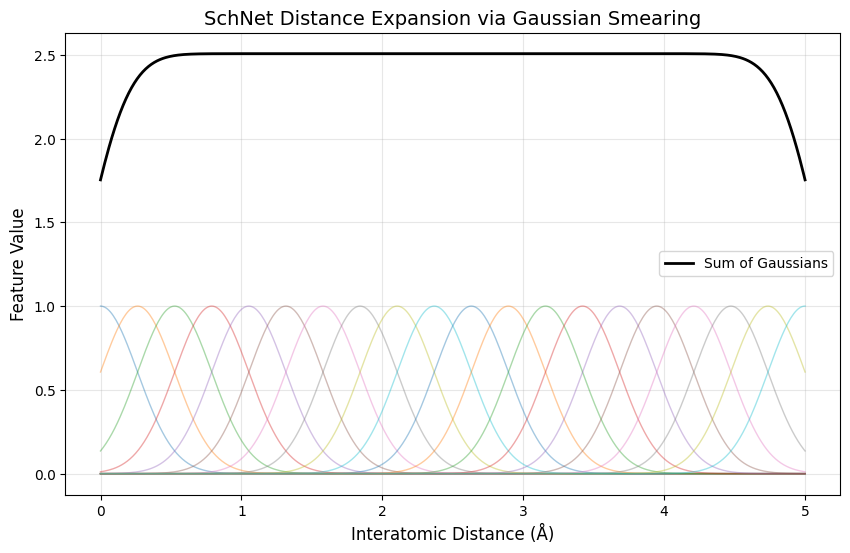

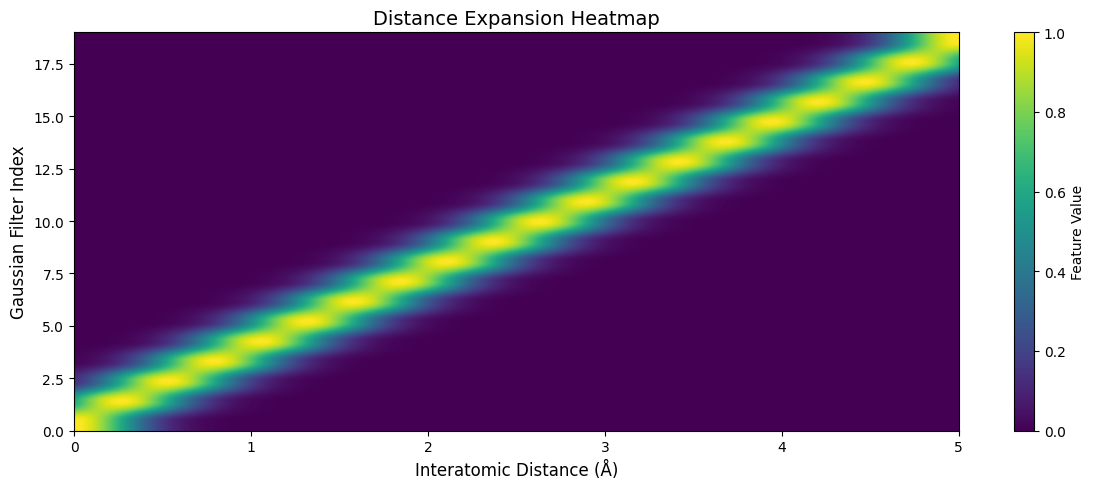

In [5]:
def visualize_distance_expansion() -> None:
    """
    Visualizes how SchNet expands interatomic distances using Gaussian smearing.
    
    This function creates two visualizations:
    1. A line plot showing individual Gaussian basis functions and their sum
    2. A heatmap showing how distances are transformed into a high-dimensional feature space
    
    The visualization helps understand how SchNet converts scalar distances into 
    feature vectors that can capture complex distance-dependent interactions.
    """
    # Create a range of distances from 0 to 5 Angstroms with 500 points
    # This gives us a fine-grained view of how distances are transformed
    distances = np.linspace(0, 5, 500)  

    # Initialize Gaussian smearing module with 20 basis functions
    # This transforms distances into 20-dimensional feature vectors
    n_gaussians = 20
    smearing = GaussianSmearing(start=0.0, stop=5.0, n_gaussians=n_gaussians)

    # Convert distances to tensor and apply Gaussian expansion
    # The expanded tensor has shape [500, 20] where each row is a feature vector
    dist_tensor = torch.tensor(distances, dtype=torch.float32)
    expanded = smearing(dist_tensor).detach().numpy()

    # Create first visualization: Line plot of basis functions
    plt.figure(figsize=(10, 6))

    # Plot each individual Gaussian basis function
    for i in range(n_gaussians):
        plt.plot(distances, expanded[:, i], alpha=0.4, lw=1)

    # Plot sum of all Gaussians to show total coverage of distance space
    plt.plot(distances, expanded.sum(axis=1), 'k-', lw=2, label='Sum of Gaussians')

    plt.title('SchNet Distance Expansion via Gaussian Smearing', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Create second visualization: Heatmap of expanded features
    plt.figure(figsize=(12, 5))
    
    # Create heatmap showing how each distance maps to feature values
    plt.imshow(expanded.T, aspect='auto', origin='lower',
               extent=[0, 5, 0, n_gaussians-1], cmap='viridis')
    plt.colorbar(label='Feature Value')
    plt.title('Distance Expansion Heatmap', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Gaussian Filter Index', fontsize=12)
    plt.tight_layout()
    plt.show()

# Create visualization of the SchNet distance expansion mechanism
visualize_distance_expansion()

### Continuous-Filter Generation Visualization

One of the key innovations of SchNet is its ability to generate filters based on interatomic distances. Let's visualize how these filters look for different distances:

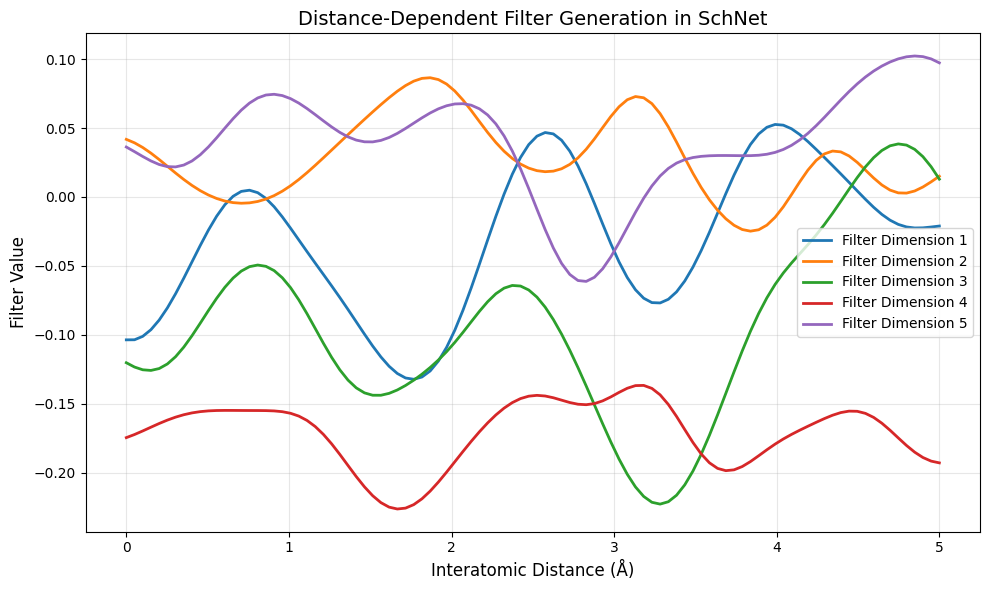

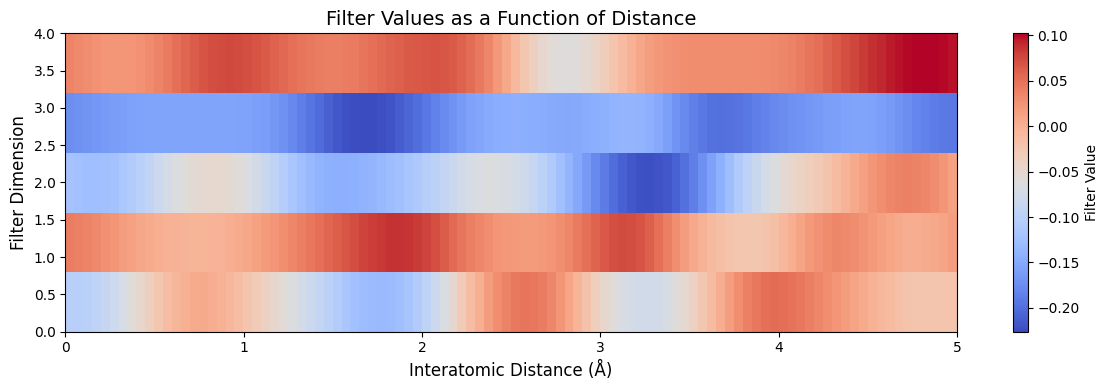

In [6]:
# Implement a simple filter-generating network to visualize
class SimpleFilterNet(nn.Module):
    """Simple neural network for generating continuous filters based on distance features.
    
    Args:
        n_filters (int): Number of input Gaussian basis functions. Default: 20
        n_out (int): Number of output filter dimensions. Default: 5
    """
    def __init__(self, n_filters: int = 20, n_out: int = 5) -> None:
        super(SimpleFilterNet, self).__init__()
        self.dense1 = nn.Linear(n_filters, 16)
        self.dense2 = nn.Linear(16, n_out) 
        self.activation = ShiftedSoftplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass to generate continuous filters.
        
        Args:
            x (torch.Tensor): Input tensor of expanded distance features [batch_size, n_filters]
            
        Returns:
            torch.Tensor: Generated filter values [batch_size, n_out]
        """
        x = self.activation(self.dense1(x))
        return self.dense2(x)

def visualize_filter_generation() -> None:
    """Visualize how SchNet generates continuous filters from interatomic distances.
    
    Creates two visualizations:
    1. Line plot showing filter values vs distance for each filter dimension
    2. Heatmap showing the full filter response across distances
    """
    # Create a range of distances to evaluate filters at
    distances = np.linspace(0, 5, 100)  # From 0 to 5 Angstroms, 100 points

    # Initialize the distance expansion and filter generation modules
    n_gaussians = 20  # Number of Gaussian basis functions
    n_features = 5    # Number of output filter dimensions
    smearing = GaussianSmearing(0.0, 5.0, n_gaussians)
    filter_net = SimpleFilterNet(n_gaussians, n_features)

    # Generate the continuous filters:
    # 1. Convert distances to tensor
    dist_tensor = torch.tensor(distances, dtype=torch.float32)
    # 2. Expand distances using Gaussian basis
    expanded = smearing(dist_tensor)  # Shape: [100, 20]
    # 3. Generate filter values
    filters = filter_net(expanded).detach().numpy()  # Shape: [100, 5]

    # Create line plot visualization
    plt.figure(figsize=(10, 6))
    for i in range(n_features):
        plt.plot(distances, filters[:, i], lw=2, label=f'Filter Dimension {i+1}')

    plt.title('Distance-Dependent Filter Generation in SchNet', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Filter Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create heatmap visualization
    plt.figure(figsize=(12, 4))
    plt.imshow(filters.T, aspect='auto', origin='lower',
               extent=[0, 5, 0, n_features-1], cmap='coolwarm')
    plt.colorbar(label='Filter Value')
    plt.title('Filter Values as a Function of Distance', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Filter Dimension', fontsize=12)
    plt.tight_layout()
    plt.show()

# Generate and display the filter visualizations
visualize_filter_generation()

### Message Passing Visualization

Now let's visualize how information flows between atoms during a SchNet forward pass. For this, we'll create a simple molecule and trace the feature updates through one interaction block:

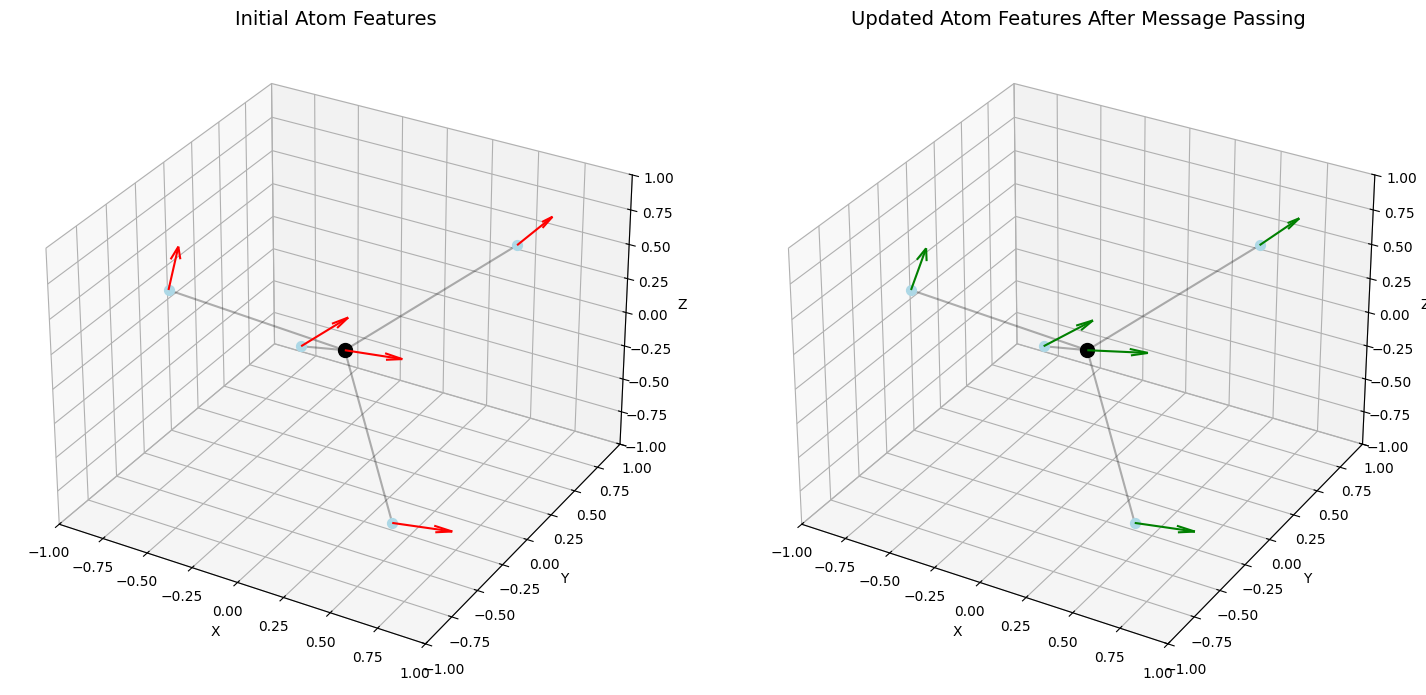

In [8]:
def visualize_message_passing() -> None:
    """
    Visualizes the message passing mechanism in SchNet using a methane molecule (CH4) example.
    
    Creates two types of visualizations:
    1. A static matplotlib 3D plot showing initial and updated atom features
    2. An interactive Plotly 3D visualization with the same information
    
    The visualization shows:
    - Atom positions in 3D space (C at center, H atoms in tetrahedral arrangement)
    - Feature vectors as arrows (red for initial, green for updated)
    - Bonds between atoms
    - How features change after one round of message passing
    """
    # Create a simple CH4 molecule (methane) with 5 atoms total
    n_atoms = 5

    # Mock embedded features - using 3D vectors for easy visualization
    # Each row represents feature vector for one atom: [x, y, z]
    features = torch.tensor([
        [1.0, 0.1, 0.1],  # C (center) - distinct feature vector
        [0.1, 0.8, 0.1],  # H1 - hydrogen-like feature vector
        [0.1, 0.1, 0.8],  # H2
        [0.8, 0.1, 0.1],  # H3
        [0.4, 0.4, 0.4],  # H4
    ], dtype=torch.float32)

    # Define 3D positions for tetrahedral structure of methane
    # C at origin, H atoms at vertices of a tetrahedron
    positions = torch.tensor([
        [0.0, 0.0, 0.0],          # C at center
        [0.6, 0.6, 0.6],          # H1
        [-0.6, -0.6, 0.6],        # H2
        [0.6, -0.6, -0.6],        # H3
        [-0.6, 0.6, -0.6],        # H4
    ], dtype=torch.float32)

    # Define connectivity between atoms (edge list)
    # Each H is connected to C, creating 8 edges (4 bidirectional connections)
    edge_index = torch.tensor([
        [0, 0, 0, 0, 1, 2, 3, 4],  # Source atoms (C->H and H->C)
        [1, 2, 3, 4, 0, 0, 0, 0]   # Target atoms
    ], dtype=torch.long)

    # Calculate interatomic distances for each edge
    source, target = edge_index
    distances = torch.norm(positions[source] - positions[target], dim=1)

    # Setup for message passing
    n_features = 3  # Using 3D features for visualization simplicity

    # Convert distances to Gaussian basis
    n_gaussians = 10
    smearing = GaussianSmearing(0.0, 2.0, n_gaussians)
    dist_expanded = smearing(distances)

    # Generate interaction filters
    filter_net = SimpleFilterNet(n_gaussians, n_features)
    filters = filter_net(dist_expanded)

    # Store initial features and prepare array for updated features
    initial_features = features.clone()
    updated_features = torch.zeros_like(features)

    # Perform one step of message passing
    for i in range(n_atoms):
        # Find all edges where current atom is the target
        mask = (target == i)

        if mask.any():
            # Get features from neighboring atoms (sources)
            sources = source[mask]
            
            # Apply filters to source features
            weighted_messages = features[sources] * filters[mask]
            
            # Aggregate messages by summing
            updated_features[i] = features[i] + weighted_messages.sum(dim=0)
        else:
            # If no incoming messages, keep original features
            updated_features[i] = features[i]

    # Normalize feature vectors for visualization clarity
    for i in range(n_atoms):
        norm = torch.norm(updated_features[i])
        if norm > 0:
            updated_features[i] = updated_features[i] / norm

    # Create static matplotlib visualization
    fig = plt.figure(figsize=(15, 7))

    # Setup for visualization
    atom_colors = ['black', 'lightblue', 'lightblue', 'lightblue', 'lightblue']
    atom_sizes = [100, 50, 50, 50, 50]  # C larger than H

    # Plot initial features (left subplot)
    ax1 = fig.add_subplot(121, projection='3d')
    _plot_molecule_state(ax1, positions, initial_features, atom_colors, atom_sizes, 
                        'Initial Atom Features', arrow_color='red')

    # Plot updated features (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    _plot_molecule_state(ax2, positions, updated_features, atom_colors, atom_sizes,
                        'Updated Atom Features After Message Passing', arrow_color='green')

    plt.tight_layout()
    plt.show()

    # Create interactive Plotly visualization
    _create_interactive_plot(positions, initial_features, updated_features, 
                           atom_colors, atom_sizes, atom_names=['C', 'H', 'H', 'H', 'H'])

def _plot_molecule_state(ax: plt.Axes, positions: torch.Tensor, features: torch.Tensor, 
                        atom_colors: list, atom_sizes: list, title: str, 
                        arrow_color: str) -> None:
    """Helper function to plot one state of the molecule (either initial or updated)."""
    # Plot atoms
    for i in range(len(positions)):
        ax.scatter(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                  c=atom_colors[i], s=atom_sizes[i], 
                  label=f"{'C' if i==0 else 'H'}{i}")

        # Plot feature vector as arrow
        ax.quiver(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                 features[i, 0].item(), features[i, 1].item(), features[i, 2].item(),
                 color=arrow_color, length=0.3, normalize=True)

    # Plot bonds
    for j in range(4):
        ax.plot([positions[0, 0].item(), positions[j+1, 0].item()],
                [positions[0, 1].item(), positions[j+1, 1].item()],
                [positions[0, 2].item(), positions[j+1, 2].item()],
                'k-', alpha=0.3)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

def _create_interactive_plot(positions: torch.Tensor, initial_features: torch.Tensor,
                           updated_features: torch.Tensor, atom_colors: list,
                           atom_sizes: list, atom_names: list) -> None:
    """Creates an interactive Plotly visualization of the molecule and its features."""
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=('Initial Features', 'After Message Passing')
    )

    def _add_atom_to_plot(fig, pos, color, size, name, idx, subplot_idx, show_legend=True):
        """Add an atom marker to the plot."""
        fig.add_trace(
            go.Scatter3d(
                x=[pos[0].item()], y=[pos[1].item()], z=[pos[2].item()],
                mode='markers',
                marker=dict(size=size, color=color),
                name=f"{name}{idx}" if show_legend else None,
                showlegend=show_legend
            ),
            row=1, col=subplot_idx
        )

    def _add_feature_vector(fig, pos, feature, color, idx, subplot_idx):
        """Add a feature vector arrow to the plot."""
        fig.add_trace(
            go.Scatter3d(
                x=[pos[0].item(), pos[0].item() + 0.3 * feature[0].item()],
                y=[pos[1].item(), pos[1].item() + 0.3 * feature[1].item()],
                z=[pos[2].item(), pos[2].item() + 0.3 * feature[2].item()],
                mode='lines',
                line=dict(color=color, width=3),
                showlegend=False
            ),
            row=1, col=subplot_idx
        )

    def _add_bond(fig, pos1, pos2, idx, subplot_idx):
        """Add a bond between two atoms to the plot."""
        fig.add_trace(
            go.Scatter3d(
                x=[pos1[0].item(), pos2[0].item()],
                y=[pos1[1].item(), pos2[1].item()],
                z=[pos1[2].item(), pos2[2].item()],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ),
            row=1, col=subplot_idx
        )

    # Add atoms and features to both subplots
    for i in range(len(positions)):
        # Add atoms
        _add_atom_to_plot(fig, positions[i], atom_colors[i], atom_sizes[i], 
                         atom_names[i], i, 1)
        _add_atom_to_plot(fig, positions[i], atom_colors[i], atom_sizes[i], 
                         atom_names[i], i, 2, show_legend=False)

        # Add feature vectors
        _add_feature_vector(fig, positions[i], initial_features[i], 'red', i, 1)
        _add_feature_vector(fig, positions[i], updated_features[i], 'green', i, 2)

        # Add bonds
        if i > 0:
            _add_bond(fig, positions[0], positions[i], i, 1)
            _add_bond(fig, positions[0], positions[i], i, 2)

    # Update layout
    fig.update_layout(
        title='SchNet Message Passing Visualization',
        scene1=dict(
            xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
            aspectmode='cube',
        ),
        scene2=dict(
            xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
            aspectmode='cube',
        ),
        legend=dict(x=0.7, y=0.9),
        width=1000,
        height=500,
    )

    fig.show()

# Run the visualization of message passing in SchNet
visualize_message_passing()

## 5. Implementing SchNet for Property Prediction <a name="implementation"></a>

Now that we understand the SchNet architecture and its key operations, let's implement a full SchNet model for molecular property prediction. We'll use the QM9 dataset, which contains quantum-mechanical properties of small organic molecules.

### The QM9 Dataset

QM9 is a widely used benchmark dataset for molecular property prediction. It contains:

- ~134k small organic molecules with up to 9 heavy atoms (C, O, N, F)
- 12 quantum-mechanical properties computed at the DFT/B3LYP level
- 3D conformations of each molecule

This makes it perfect for training and evaluating SchNet models.

### Training a SchNet Model

Let's use the schnetpack library to set up and train a SchNet model on the QM9 dataset. We'll predict the HOMO-LUMO gap, an important property for electronic applications.

In [10]:
def explore_qm9_dataset() -> Tuple[QM9, List[str]]:
    """Explore the QM9 dataset.
    
    This function downloads and loads the QM9 dataset, which contains quantum-mechanical
    properties of small organic molecules. It prints basic information about the dataset
    and returns the dataset object along with property names.
    
    Returns:
        Tuple containing:
            - QM9: The loaded QM9 dataset object
            - List[str]: List of target property names in the dataset
    """
    # Download and load QM9 dataset from disk or web if not present
    # QM9 class handles caching automatically
    dataset = QM9(root='data/QM9')

    # Print total number of molecules in dataset
    print(f"Dataset size: {len(dataset)} molecules")

    # Examine the first molecule to understand data structure
    # Each molecule is represented as a Data object with attributes:
    # - z: atomic numbers 
    # - pos: 3D coordinates
    # - y: target properties
    data = dataset[0]
    print("\nSample molecule data:")
    print(f"Atomic numbers: {data.z}")  # Integer tensor of atomic numbers
    print(f"Positions shape: {data.pos.shape}")  # (num_atoms, 3) float tensor
    print(f"Target properties shape: {data.y.shape}")  # (1, num_properties) float tensor

    # List of all quantum mechanical properties available in QM9
    # These are computed at DFT/B3LYP level of theory
    target_names = [
        'dipole moment',
        'isotropic polarizability', 
        'HOMO energy',
        'LUMO energy',
        'HOMO-LUMO gap',
        'electronic spatial extent',
        'zero point vibrational energy',
        'internal energy at 0K',
        'internal energy at 298.15K',
        'enthalpy at 298.15K',
        'free energy at 298.15K',
        'heat capacity at 298.15K'
    ]

    # Print all available properties with their index
    # Index is used when selecting specific property for training
    print("\nAvailable target properties:")
    for i, name in enumerate(target_names):
        print(f"{i}: {name}")

    return dataset, target_names

# Load and explore the QM9 dataset
qm9_dataset, target_names = explore_qm9_dataset()

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [01:16<00:00, 1759.97it/s]


Dataset size: 130831 molecules

Sample molecule data:
Atomic numbers: tensor([6, 1, 1, 1, 1])
Positions shape: torch.Size([5, 3])
Target properties shape: torch.Size([1, 19])

Available target properties:
0: dipole moment
1: isotropic polarizability
2: HOMO energy
3: LUMO energy
4: HOMO-LUMO gap
5: electronic spatial extent
6: zero point vibrational energy
7: internal energy at 0K
8: internal energy at 298.15K
9: enthalpy at 298.15K
10: free energy at 298.15K
11: heat capacity at 298.15K


Done!


Loading QM9 dataset...
Target property: HOMO-LUMO gap (index: 4)
Dataset split: 104664 train, 13083 validation, 13084 test

Sample batch:
z shape: torch.Size([597])
pos shape: torch.Size([597, 3])
batch shape: torch.Size([597])
y shape: torch.Size([32, 19])

Target property statistics:
Mean: 6.8585, Std: 1.2842


/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning:

It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.

/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning:

It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._dat


Starting training...
Epoch 1/10: Train Loss: 0.7363, Valid Loss: 0.3049, Train MAE: 0.5626, Valid MAE: 0.5941
Epoch 2/10: Train Loss: 0.1651, Valid Loss: 0.1116, Train MAE: 0.4065, Valid MAE: 0.3384
Epoch 3/10: Train Loss: 0.1137, Valid Loss: 0.0865, Train MAE: 0.3335, Valid MAE: 0.2940
Epoch 4/10: Train Loss: 0.0802, Valid Loss: 0.0892, Train MAE: 0.2788, Valid MAE: 0.3071
Epoch 5/10: Train Loss: 0.0610, Valid Loss: 0.0468, Train MAE: 0.2423, Valid MAE: 0.2141
Epoch 6/10: Train Loss: 0.0479, Valid Loss: 0.0370, Train MAE: 0.2149, Valid MAE: 0.1882
Epoch 7/10: Train Loss: 0.0404, Valid Loss: 0.0467, Train MAE: 0.1974, Valid MAE: 0.2190
Epoch 8/10: Train Loss: 0.0339, Valid Loss: 0.0418, Train MAE: 0.1807, Valid MAE: 0.2105
Epoch 9/10: Train Loss: 0.0290, Valid Loss: 0.0288, Train MAE: 0.1668, Valid MAE: 0.1718
Epoch 10/10: Train Loss: 0.0256, Valid Loss: 0.0236, Train MAE: 0.1560, Valid MAE: 0.1529

Test Results:
Loss: 0.0241
MAE: 0.1538
R²: 0.9761


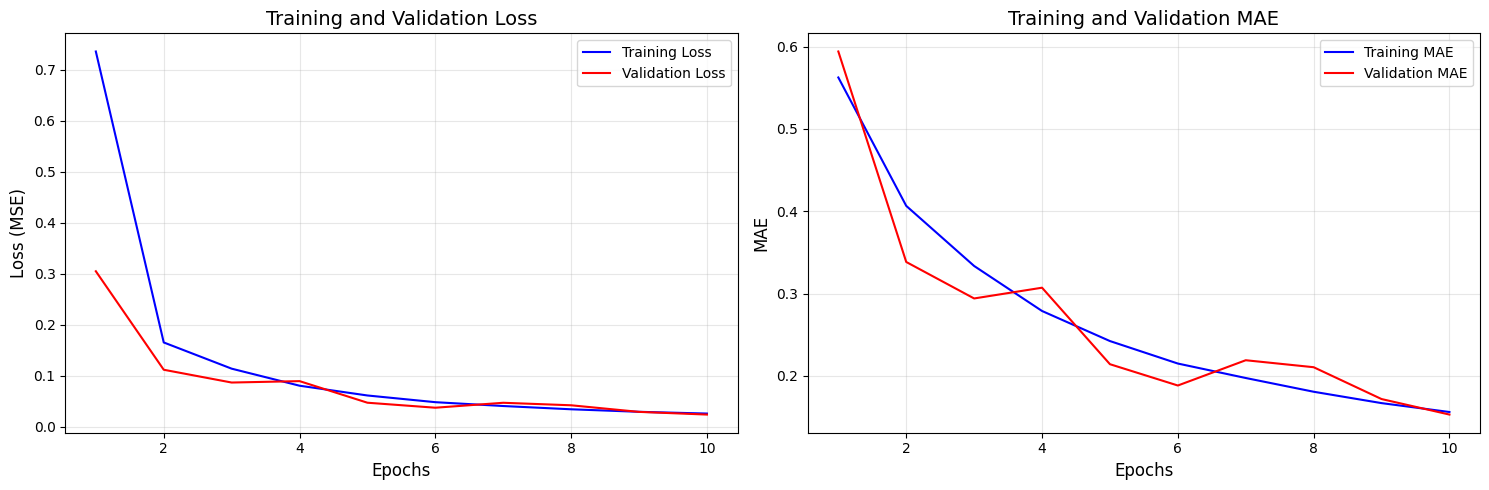

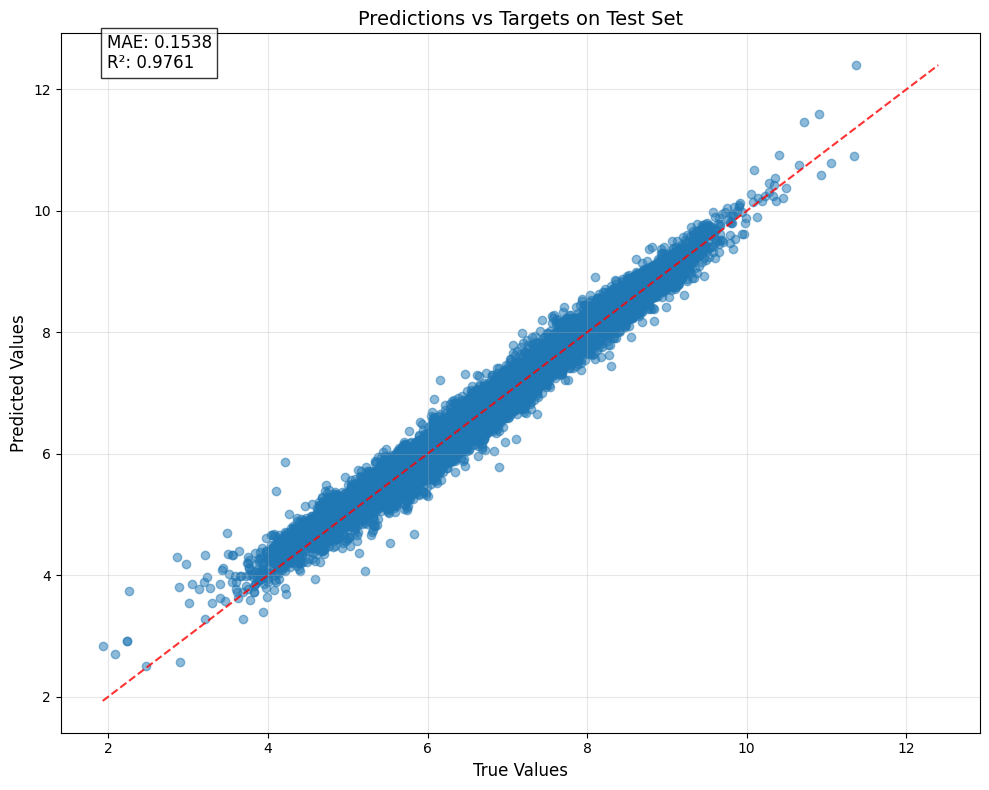

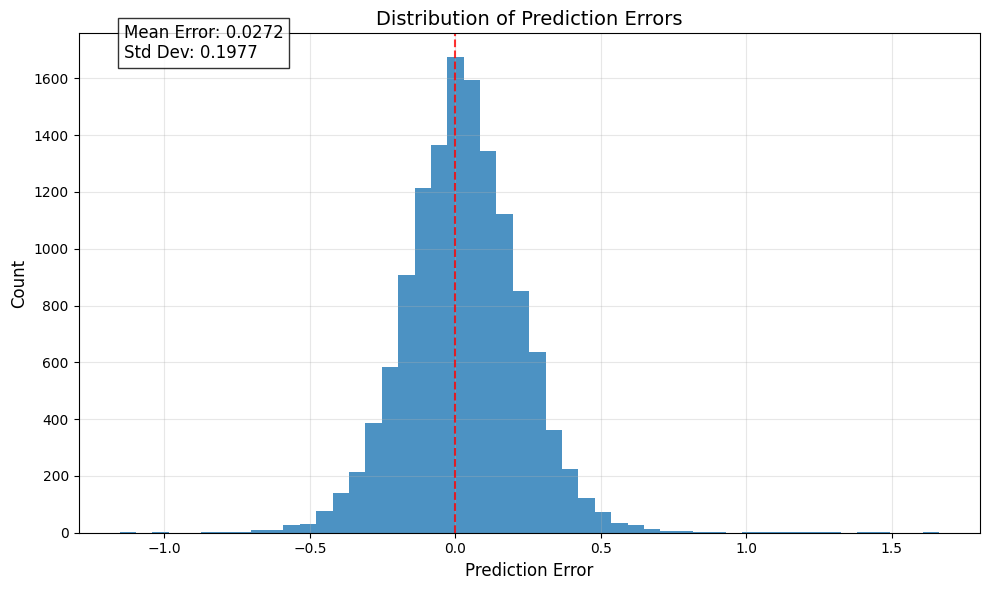

In [13]:
class SchNetForQM9(nn.Module):
    """SchNet model for QM9 property prediction.
    
    This model implements the SchNet architecture for predicting molecular properties
    from the QM9 dataset. It uses continuous-filter convolutional layers to model
    atomic interactions.
    """
    def __init__(self, hidden_channels: int = 128, num_filters: int = 128, 
                 num_interactions: int = 6, num_gaussians: int = 50, 
                 cutoff: float = 10.0, target_property: int = 4) -> None:
        """Initialize SchNet model.
        
        Args:
            hidden_channels: Dimension of hidden node features
            num_filters: Number of filters in convolutional layers
            num_interactions: Number of interaction blocks
            num_gaussians: Number of Gaussian functions for distance expansion
            cutoff: Cutoff distance for interactions
            target_property: Index of QM9 property to predict
        """
        super(SchNetForQM9, self).__init__()

        self.target_property = target_property

        # Initialize the SchNet model with specified architecture parameters
        self.schnet = SchNet(
            hidden_channels=hidden_channels,
            num_filters=num_filters,
            num_interactions=num_interactions,
            num_gaussians=num_gaussians,
            cutoff=cutoff
        )

    def forward(self, z: torch.Tensor, pos: torch.Tensor, 
                batch: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Forward pass through the SchNet model.

        Args:
            z: Atomic numbers [num_atoms]
            pos: Atomic positions [num_atoms, 3]
            batch: Batch assignment for atoms [num_atoms]

        Returns:
            Predicted property value for each molecule in the batch
        """
        return self.schnet(z, pos, batch)

#  Training SchNet on QM9 

def train_schnet_model(target_property: int = 4, batch_size: int = 32, 
                      epochs: int = 30, learning_rate: float = 0.0005,
                      hidden_channels: int = 128, num_filters: int = 128, 
                      num_interactions: int = 6) -> Tuple[SchNetForQM9, Dict]:
    """Train a SchNet model on QM9 dataset.

    This function handles the complete training pipeline including:
    - Dataset loading and splitting
    - Model initialization
    - Training loop with validation
    - Final testing and metric computation
    - Model saving

    Args:
        target_property: Index of property to predict (default: 4 for HOMO-LUMO gap)
        batch_size: Number of molecules per batch
        epochs: Number of training epochs
        learning_rate: Learning rate for Adam optimizer
        hidden_channels: Hidden embedding size in SchNet
        num_filters: Number of filters in SchNet
        num_interactions: Number of interaction blocks in SchNet

    Returns:
        Tuple containing:
        - Trained SchNet model
        - Dictionary with training history and evaluation metrics
    """
    # Load full QM9 dataset
    print("Loading QM9 dataset...")
    dataset = QM9(root='data/QM9')

    # List of available quantum properties in QM9
    target_names = [
        'dipole moment',
        'isotropic polarizability',
        'HOMO energy',
        'LUMO energy',
        'HOMO-LUMO gap',
        'electronic spatial extent',
        'zero point vibrational energy',
        'internal energy at 0K',
        'internal energy at 298.15K',
        'enthalpy at 298.15K',
        'free energy at 298.15K',
        'heat capacity at 298.15K'
    ]
    property_name = target_names[target_property]
    print(f"Target property: {property_name} (index: {target_property})")

    # Split dataset into train/validation/test sets (80%/10%/10%)
    train_size = int(0.8 * len(dataset))
    valid_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - valid_size

    # Create dataset splits
    train_dataset, valid_test_dataset = torch.utils.data.random_split(
        dataset, [train_size, valid_size + test_size])
    valid_dataset, test_dataset = torch.utils.data.random_split(
        valid_test_dataset, [valid_size, test_size])

    print(f"Dataset split: {train_size} train, {valid_size} validation, {test_size} test")

    # Create data loaders for batch processing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Inspect a sample batch to verify data structure
    batch = next(iter(train_loader))
    print(f"\nSample batch:")
    print(f"z shape: {batch.z.shape}")
    print(f"pos shape: {batch.pos.shape}")
    print(f"batch shape: {batch.batch.shape}")
    print(f"y shape: {batch.y.shape}")

    # Calculate normalization statistics for target property
    mean = dataset.data.y[:, target_property].mean().item()
    std = dataset.data.y[:, target_property].std().item()
    print(f"\nTarget property statistics:")
    print(f"Mean: {mean:.4f}, Std: {std:.4f}")

    # Initialize model and move to device (GPU if available)
    model = SchNetForQM9(
        hidden_channels=hidden_channels,
        num_filters=num_filters,
        num_interactions=num_interactions,
        target_property=target_property
    ).to(device)

    # Setup optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Initialize training history dictionary
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_mae': [],
        'valid_mae': []
    }

    # Training loop
    print("\nStarting training...")
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_mae = 0

        for batch in train_loader:
            batch = batch.to(device)
            
            # Forward pass and prediction
            pred = model(batch.z, batch.pos, batch.batch)

            # Normalize target property
            target = batch.y[:, target_property].unsqueeze(1)
            target = (target - mean) / std

            # Compute loss
            loss = loss_fn(pred, target)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate batch metrics
            train_loss += loss.item() * batch.num_graphs

            # Calculate MAE on denormalized predictions
            pred_denorm = pred * std + mean
            target_denorm = target * std + mean
            mae = torch.abs(pred_denorm - target_denorm).mean().item()
            train_mae += mae * batch.num_graphs

        # Calculate average training metrics
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        valid_loss = 0
        valid_mae = 0

        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                
                # Forward pass
                pred = model(batch.z, batch.pos, batch.batch)

                # Normalize target
                target = batch.y[:, target_property].unsqueeze(1)
                target = (target - mean) / std

                # Compute validation loss
                loss = loss_fn(pred, target)
                valid_loss += loss.item() * batch.num_graphs

                # Calculate MAE on denormalized predictions
                pred_denorm = pred * std + mean
                target_denorm = target * std + mean
                mae = torch.abs(pred_denorm - target_denorm).mean().item()
                valid_mae += mae * batch.num_graphs

        # Calculate average validation metrics
        valid_loss /= len(valid_loader.dataset)
        valid_mae /= len(valid_loader.dataset)

        # Store epoch metrics
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_mae'].append(train_mae)
        history['valid_mae'].append(valid_mae)

        # Print epoch progress
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Train MAE: {train_mae:.4f}, "
              f"Valid MAE: {valid_mae:.4f}")

    # Final evaluation on test set
    model.eval()
    test_loss = 0
    test_mae = 0
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            # Forward pass
            pred = model(batch.z, batch.pos, batch.batch)

            # Normalize target
            target = batch.y[:, target_property].unsqueeze(1)
            target = (target - mean) / std

            # Compute test loss
            loss = loss_fn(pred, target)
            test_loss += loss.item() * batch.num_graphs

            # Calculate MAE on denormalized predictions
            pred_denorm = pred * std + mean
            target_denorm = target * std + mean
            mae = torch.abs(pred_denorm - target_denorm).mean().item()
            test_mae += mae * batch.num_graphs

            # Store predictions and targets
            test_preds.extend(pred_denorm.cpu().numpy())
            test_targets.extend(target_denorm.cpu().numpy())

    # Calculate final test metrics
    test_loss /= len(test_loader.dataset)
    test_mae /= len(test_loader.dataset)

    # Convert predictions to numpy arrays
    test_preds = np.array(test_preds).squeeze()
    test_targets = np.array(test_targets).squeeze()

    # Calculate R² score
    test_r2 = r2_score(test_targets, test_preds)

    # Print final test results
    print(f"\nTest Results:")
    print(f"Loss: {test_loss:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")

    # Store test results in history
    history.update({
        'test_loss': test_loss,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_preds': test_preds,
        'test_targets': test_targets
    })

    # Save model checkpoint
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'mean': mean,
        'std': std,
        'target_property': target_property,
        'hidden_channels': hidden_channels,
        'num_filters': num_filters,
        'num_interactions': num_interactions
    }, f'schnet_qm9_prop{target_property}.pt')

    return model, history

def plot_training_results(history: Dict) -> None:
    """Visualize training results and model performance.
    
    Creates multiple plots:
    1. Training/validation loss curves
    2. Training/validation MAE curves
    3. Prediction vs target scatter plot (if test results available)
    4. Error distribution histogram (if test results available)
    
    Args:
        history: Dictionary containing training history and test results
    """
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss curves
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['valid_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot MAE curves
    ax2.plot(epochs, history['train_mae'], 'b-', label='Training MAE')
    ax2.plot(epochs, history['valid_mae'], 'r-', label='Validation MAE')
    ax2.set_title('Training and Validation MAE', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plot test results if available
    if 'test_preds' in history and 'test_targets' in history:
        # Scatter plot of predictions vs targets
        plt.figure(figsize=(10, 8))
        plt.scatter(history['test_targets'], history['test_preds'], alpha=0.5)

        # Add identity line
        min_val = min(history['test_targets'].min(), history['test_preds'].min())
        max_val = max(history['test_targets'].max(), history['test_preds'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        plt.title('Predictions vs Targets on Test Set', fontsize=14)
        plt.xlabel('True Values', fontsize=12)
        plt.ylabel('Predicted Values', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add performance metrics
        plt.text(0.05, 0.95, f"MAE: {history['test_mae']:.4f}\nR²: {history['test_r2']:.4f}",
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Plot error distribution
        errors = history['test_preds'] - history['test_targets']
        plt.figure(figsize=(10, 6))

        plt.hist(errors, bins=50, alpha=0.8)
        plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)

        plt.title('Distribution of Prediction Errors', fontsize=14)
        plt.xlabel('Prediction Error', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add error statistics
        plt.text(0.05, 0.95, f"Mean Error: {errors.mean():.4f}\nStd Dev: {errors.std():.4f}",
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.show()

# Train model on HOMO-LUMO gap prediction
model, history = train_schnet_model(target_property=4, epochs=10)
plot_training_results(history)

## 6. Visualizing Learned Molecular Representations <a name="visualize-learned-representation"></a>

One of the most powerful aspects of SchNet is its ability to learn meaningful representations of atoms and molecules. Let's visualize these learned representations to gain insights into what the model is learning.

### Atom Embedding Visualization

First, let's visualize the learned atom embeddings to see how SchNet represents different elements:

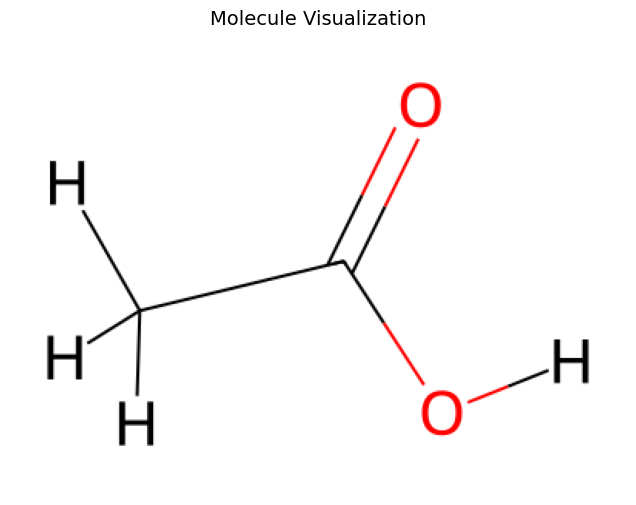

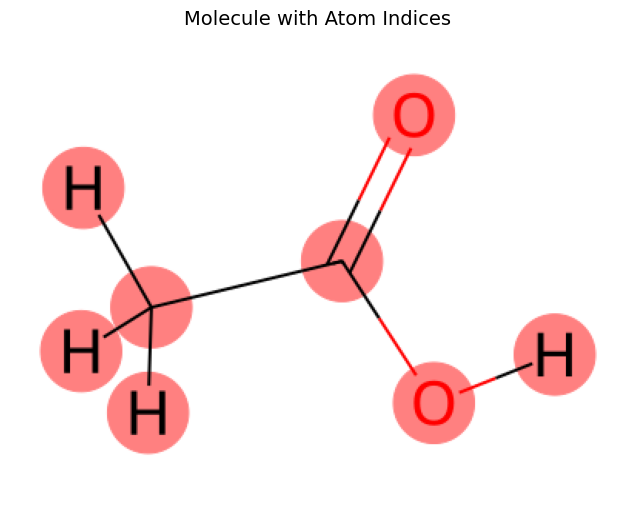

Molecule: CC(=O)O
Atoms: tensor([6, 6, 8, 8, 1, 1, 1, 1])
Positions shape: torch.Size([8, 3])


/tmp/ipykernel_166234/518879230.py:116: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_166234/518879230.py:117: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_166234/518879230.py:135: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



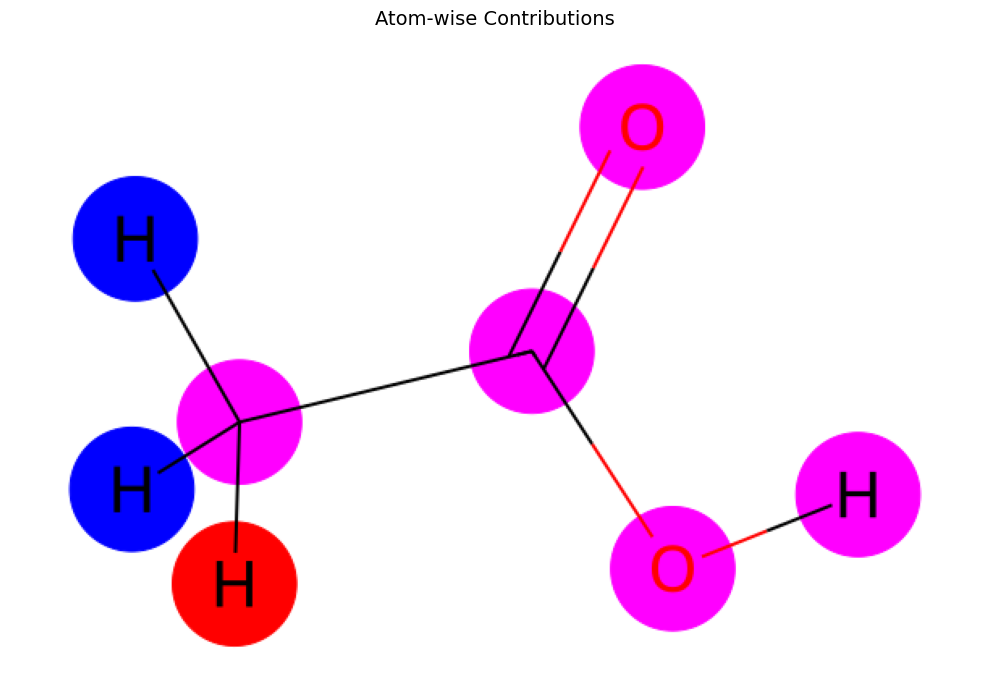

Atom-wise Contributions:


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import numpy as np
import torch
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from typing import Tuple, List, Dict, Optional, Union

def molecule_from_smiles(smiles: str) -> Chem.Mol:
    """Create an RDKit molecule from SMILES string with 3D coordinates.
    
    Args:
        smiles: SMILES string representation of molecule
        
    Returns:
        RDKit molecule with 3D coordinates
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens
    AllChem.EmbedMolecule(mol)  # Generate 3D coordinates
    AllChem.MMFFOptimizeMolecule(mol)  # Optimize geometry
    return mol

def visualize_molecule(mol: Chem.Mol) -> None:
    """Visualize molecule using RDKit, showing both regular and atom-indexed views.
    
    Args:
        mol: RDKit molecule to visualize
    """
    # Regular molecule view
    img = Draw.MolToImage(mol, size=(400, 300))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Molecule Visualization", fontsize=14)
    plt.show()

    # View with atom indices for reference
    img = Draw.MolToImage(mol, size=(400, 300), highlightAtoms=range(mol.GetNumAtoms()))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Molecule with Atom Indices", fontsize=14)
    plt.show()

def extract_atom_contributions(model: torch.nn.Module, 
                             z: torch.Tensor, 
                             pos: torch.Tensor, 
                             batch: Optional[torch.Tensor] = None) -> np.ndarray:
    """Extract atom-wise contributions from SchNet model.
    
    Args:
        model: Trained SchNet model
        z: Atomic numbers tensor
        pos: Atomic positions tensor
        batch: Batch assignments for atoms (optional)
        
    Returns:
        Array of atom-wise contributions to the prediction
    """
    # Put model in eval mode for inference
    model.eval()

    # Move all inputs to same device as model
    z = z.to(device)
    pos = pos.to(device)
    if batch is not None:
        batch = batch.to(device)

    # Get the atom embeddings
    with torch.no_grad():
        # Handle different SchNet implementations
        if hasattr(model, 'schnet'):
            # For custom SchNetForQM9 model
            h = model.schnet.embedding(z)

            # Apply interaction blocks sequentially
            for interaction in model.schnet.interactions:
                h = h + interaction(h, z, pos, batch)

            # Get final atom contributions
            atom_contrib = model.schnet.output_network(h)

        else:
            # For standard PyG SchNet model
            h = model.embedding(z)

            # Apply interaction blocks
            for interaction in model.interactions:
                h = h + interaction(h, z, pos, batch)

            # Get final atom contributions
            atom_contrib = model.output_network(h)

    return atom_contrib.cpu().numpy()

def visualize_atom_contributions(mol: Chem.Mol, atom_contrib: np.ndarray) -> None:
    """Visualize atom-wise contributions in a molecule through colors and plots.
    
    Args:
        mol: RDKit molecule
        atom_contrib: Array of contribution values for each atom
    """
    # Normalize contributions to [0,1] range for visualization
    min_contrib = atom_contrib.min()
    max_contrib = atom_contrib.max()
    norm_contrib = (atom_contrib - min_contrib) / (max_contrib - min_contrib)

    # Create color mapping for atoms (red=high contribution, blue=low)
    atom_colors = {}
    for i, contrib in enumerate(norm_contrib):
        r = int(255 * contrib)
        b = int(255 * (1 - contrib))
        atom_colors[i] = (r, 0, b)

    # Generate 2D depiction with colored atoms
    drawer = Draw.MolDraw2DCairo(600, 400)
    Draw.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=range(mol.GetNumAtoms()),
                               highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert drawing to image and display
    image = Image.open(BytesIO(img))
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Atom-wise Contributions", fontsize=14)

    # Create colormap for reference
    cmap = cm.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=min_contrib, vmax=max_contrib)

    plt.tight_layout()
    plt.show()

    # Print numerical contributions for each atom
    print("Atom-wise Contributions:")
    for i, contrib in enumerate(atom_contrib):
        atom = mol.GetAtomWithIdx(i)
        atom_symbol = atom.GetSymbol()
        print(f"Atom {i} ({atom_symbol}): {contrib:.4f}")

    # Create sorted bar plot of contributions
    plt.figure(figsize=(12, 6))
    atom_symbols = [mol.GetAtomWithIdx(i).GetSymbol() + str(i) for i in range(len(atom_contrib))]

    # Sort contributions for better visualization
    sorted_indices = np.argsort(atom_contrib.flatten())
    sorted_contrib = atom_contrib.flatten()[sorted_indices]
    sorted_symbols = [atom_symbols[i] for i in sorted_indices]

    plt.bar(range(len(sorted_contrib)), sorted_contrib)
    plt.xticks(range(len(sorted_contrib)), sorted_symbols, rotation=90)
    plt.xlabel('Atom', fontsize=12)
    plt.ylabel('Contribution', fontsize=12)
    plt.title('Atom-wise Contributions to Prediction', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def visualize_atom_contributions_example() -> None:
    """Example function demonstrating atom contribution visualization workflow."""
    # Create example molecule (acetic acid)
    smiles = "CC(=O)O"
    mol = molecule_from_smiles(smiles)
    visualize_molecule(mol)

    # Convert molecular representation to SchNet input format
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    z = torch.tensor(atoms, dtype=torch.long)

    # Extract 3D coordinates
    conf = mol.GetConformer()
    positions = []
    for i in range(mol.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        positions.append([pos.x, pos.y, pos.z])
    pos = torch.tensor(positions, dtype=torch.float)

    # Print molecule information
    print(f"Molecule: {smiles}")
    print(f"Atoms: {z}")
    print(f"Positions shape: {pos.shape}")

    # Generate random contributions for demonstration
    # In practice, these would come from extract_atom_contributions(model, z, pos)
    atom_contrib = np.random.randn(len(atoms), 1)
    visualize_atom_contributions(mol, atom_contrib)

# Run the example visualization
visualize_atom_contributions_example()

### Visualizing SchNet Activations

Let's also visualize the activations within the SchNet model to better understand how it processes molecular information:

Atomic numbers (z): tensor([6, 6, 8, 8, 1, 1, 1, 1]) (type: torch.int64)
Positions: tensor([[-0.9531, -0.1397, -0.0160],
        [ 0.4680,  0.2856,  0.1519],
        [ 0.8664,  1.2598,  0.7665],
        [ 1.3285, -0.5431, -0.4675],
        [-1.6058,  0.5662,  0.5052],
        [-1.0963, -1.1327,  0.4172],
        [-1.2166, -0.1411, -1.0765],
        [ 2.2090, -0.1550, -0.2808]]) (type: torch.float32)
Batch: tensor([0, 0, 0, 0, 0, 0, 0, 0]) (type: torch.int64)
Error visualizing activations: mat1 and mat2 shapes cannot be multiplied (1x8 and 32x64)

Debug information:
embedding.weight: shape=torch.Size([100, 64]), dtype=torch.float32
interactions.0.mlp.0.weight: shape=torch.Size([64, 32]), dtype=torch.float32
interactions.0.mlp.0.bias: shape=torch.Size([64]), dtype=torch.float32
interactions.0.mlp.2.weight: shape=torch.Size([64, 64]), dtype=torch.float32
interactions.0.mlp.2.bias: shape=torch.Size([64]), dtype=torch.float32
interactions.0.conv.lin1.weight: shape=torch.Size([64, 64]), dtyp

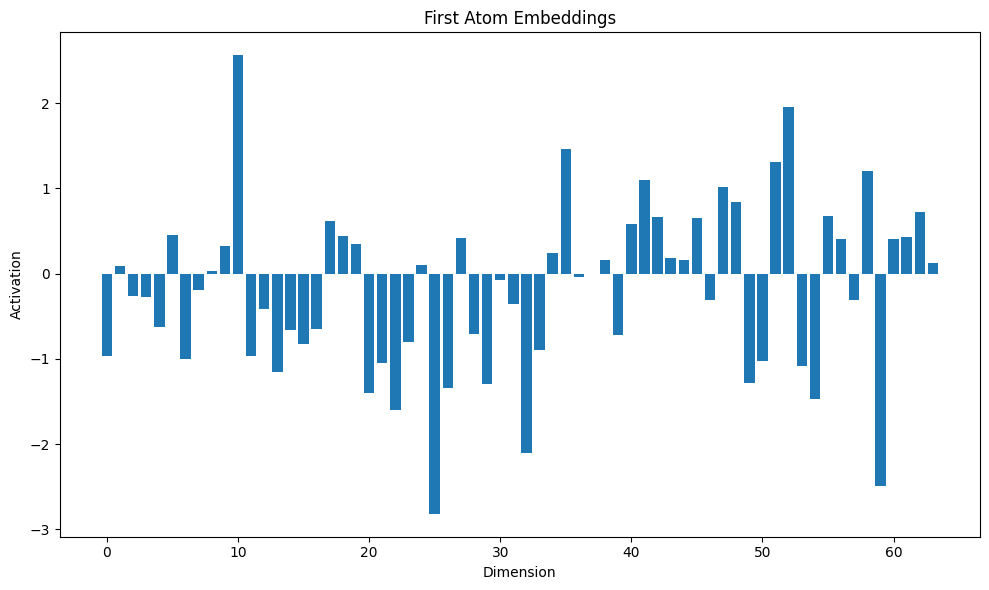

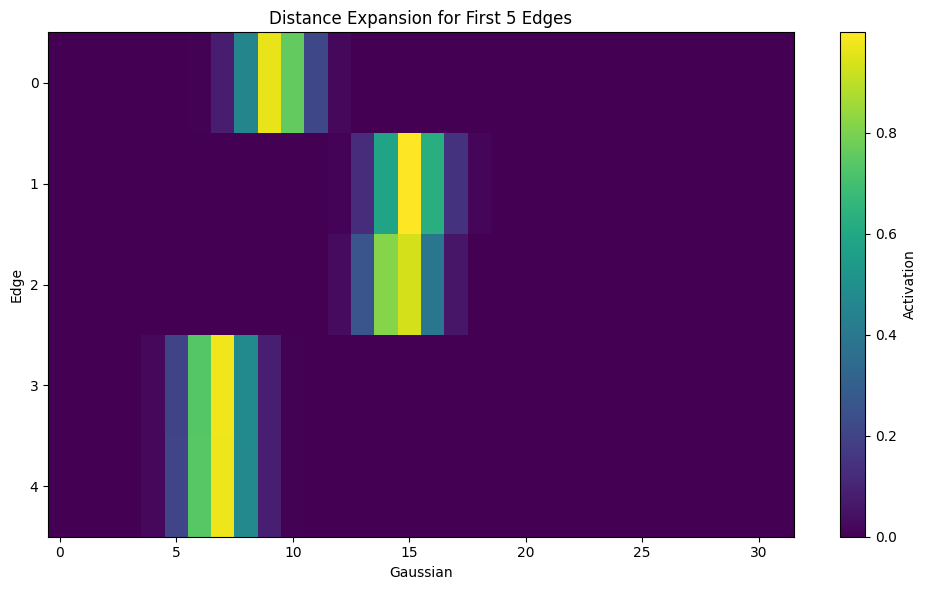

In [15]:
def visualize_schnet_activations(model: SchNet, z: torch.Tensor, pos: torch.Tensor, batch: Optional[torch.Tensor] = None) -> List[Tuple[str, np.ndarray]]:
    """Visualize activations in the SchNet model by plotting statistics and distributions.
    
    Args:
        model: The SchNet model to analyze
        z: Tensor of atomic numbers
        pos: Tensor of atomic positions
        batch: Optional batch assignment tensor for multiple molecules
        
    Returns:
        List of tuples containing layer names and their activation arrays
    """
    # Put model in eval mode for inference
    model.eval()

    # Move all input tensors to the model's device
    z = z.to(device)
    pos = pos.to(device)
    if batch is None:
        # If no batch is provided, assume all atoms belong to the same molecule (batch 0)
        batch = torch.zeros_like(z)
    batch = batch.to(device)

    # Container to store activations from each layer
    activations = []

    # Extract activations layer by layer
    with torch.no_grad():
        # Get initial atom embeddings from embedding layer
        h = model.embedding(z)
        activations.append(('embedding', h.cpu().numpy()))

        # Compute interaction graph (edges between atoms)
        edge_index, edge_weight = model.interaction_graph(pos, batch)
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)

        # Expand distances using radial basis functions
        edge_attr = model.distance_expansion(edge_weight)

        # Apply each interaction block and collect activations
        for i, interaction in enumerate(model.interactions):
            # Update atom features through interaction
            h = h + interaction(h, edge_index, edge_attr, batch)
            activations.append((f'interaction_{i+1}', h.cpu().numpy()))

        # Get final atomic contributions from output network
        atom_output = model.output_network(h)
        activations.append(('output', atom_output.cpu().numpy()))

    # Plot 1: Activation statistics across layers
    plt.figure(figsize=(12, 6))

    for i, (name, activation) in enumerate(activations):
        # Compute basic statistics for this layer
        mean_act = np.mean(activation)
        std_act = np.std(activation)
        max_act = np.max(activation)
        min_act = np.min(activation)

        # Plot min-max range as black line
        x = i
        plt.plot([x, x], [min_act, max_act], 'k-', alpha=0.3)
        # Plot mean as red dot
        plt.plot(x, mean_act, 'ro', markersize=8)
        # Plot standard deviation range as red line
        plt.plot([x, x], [mean_act - std_act, mean_act + std_act], 'r-', linewidth=2)

    plt.xticks(range(len(activations)), [name for name, _ in activations], rotation=45)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Activation', fontsize=12)
    plt.title('SchNet Activation Statistics Through Layers', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Distribution of activations in each layer
    plt.figure(figsize=(15, 8))

    for i, (name, activation) in enumerate(activations):
        plt.subplot(2, len(activations)//2 + len(activations)%2, i+1)

        # Flatten activation values for histogram
        flat_act = activation.flatten()

        # Plot histogram of activation values
        plt.hist(flat_act, bins=30, alpha=0.8)
        plt.title(name, fontsize=10)
        plt.xlabel('Activation', fontsize=8)
        plt.ylabel('Count', fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.suptitle('Activation Distributions Across Layers', fontsize=14, y=1.02)
    plt.show()

    # Plot 3: Heatmap showing activation patterns for a single atom
    atom_idx = 0  # Focus on first atom

    plt.figure(figsize=(12, 6))

    # Extract activation values for the selected atom across all layers
    atom_activations = np.array([activation[atom_idx] for _, activation in activations])

    # Create heatmap visualization
    plt.imshow(atom_activations, aspect='auto', cmap='viridis')
    plt.colorbar(label='Activation')
    plt.xticks(range(atom_activations.shape[1]), [f'Dim {i+1}' for i in range(atom_activations.shape[1])],
               rotation=90, fontsize=8)
    plt.yticks(range(len(activations)), [name for name, _ in activations])
    plt.title(f'Activations for Atom {atom_idx} Across Layers', fontsize=14)
    plt.tight_layout()
    plt.show()

    return activations

def visualize_activations_example() -> Optional[List[Tuple[str, np.ndarray]]]:
    """Example function demonstrating SchNet activation visualization.
    
    Creates a small SchNet model and visualizes its activations on a simple molecule.
    
    Returns:
        List of activation arrays if successful, None if visualization fails
    """
    # Create a small SchNet model for demonstration
    model = SchNet(
        hidden_channels=64,  # Smaller hidden dimension for clearer visualization
        num_filters=64,
        num_interactions=3,  # Fewer interactions to simplify visualization
        num_gaussians=32,
        cutoff=5.0
    ).to(device)

    # Create example molecule (acetic acid)
    smiles = "CC(=O)O"  
    mol = molecule_from_smiles(smiles)

    # Convert molecular representation to SchNet input format
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    z = torch.tensor(atoms, dtype=torch.long)

    # Extract 3D coordinates from molecule
    conf = mol.GetConformer()
    positions = []
    for i in range(mol.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        positions.append([pos.x, pos.y, pos.z])
    pos = torch.tensor(positions, dtype=torch.float32)

    # Create batch indices (all atoms in same molecule)
    batch = torch.zeros(len(atoms), dtype=torch.long)

    # Print input tensor information for debugging
    print(f"Atomic numbers (z): {z} (type: {z.dtype})")
    print(f"Positions: {pos} (type: {pos.dtype})")
    print(f"Batch: {batch} (type: {batch.dtype})")

    # Try to visualize activations with error handling
    try:
        activations = visualize_schnet_activations(model, z, pos, batch)
        return activations
    except Exception as e:
        print(f"Error visualizing activations: {e}")

        # Print detailed model information for debugging
        print("\nDebug information:")
        for name, param in model.named_parameters():
            print(f"{name}: shape={param.shape}, dtype={param.dtype}")

        # Attempt direct forward pass for debugging
        print("\nTrying direct forward pass...")
        try:
            model.eval()
            with torch.no_grad():
                # Compute interaction graph
                edge_index, edge_weight = model.interaction_graph(pos, batch)
                print(f"Edge index: {edge_index.shape}, dtype={edge_index.dtype}")
                print(f"Edge weight: {edge_weight.shape}, dtype={edge_weight.dtype}")

                # Get embeddings
                h = model.embedding(z)
                print(f"Embeddings: {h.shape}, dtype={h.dtype}")

                # Test first interaction block
                edge_attr = model.distance_expansion(edge_weight)
                print(f"Edge attr: {edge_attr.shape}, dtype={edge_attr.dtype}")

                h_out = model.interactions[0](h, edge_index, edge_attr, batch)
                print(f"After interaction: {h_out.shape}, dtype={h_out.dtype}")

                print("Forward pass successful!")
        except Exception as e:
            print(f"Error in forward pass: {e}")

            # Try simplified visualization with explicit type handling
            print("\nAttempting with explicit type conversions...")
            try:
                def simple_visualization() -> np.ndarray:
                    """Simplified visualization function for debugging."""
                    model.eval()
                    with torch.no_grad():
                        # Convert inputs to appropriate types
                        z_long = z.long().to(device)
                        h = model.embedding(z_long)
                        print(f"Embeddings: {h.shape}, dtype={h.dtype}")

                        pos_float = pos.float().to(device)
                        batch_long = batch.long().to(device)
                        edge_index, edge_weight = model.interaction_graph(pos_float, batch_long)
                        edge_index = edge_index.to(device)
                        edge_weight = edge_weight.to(device)

                        edge_attr = model.distance_expansion(edge_weight)

                        # Visualize embeddings
                        print(f"First layer activation shape: {h.shape}")
                        h_numpy = h.cpu().numpy()
                        plt.figure(figsize=(10, 6))
                        plt.bar(range(h_numpy.shape[1]), h_numpy[0])
                        plt.title("First Atom Embeddings")
                        plt.xlabel("Dimension")
                        plt.ylabel("Activation")
                        plt.tight_layout()
                        plt.show()

                        # Visualize distance expansion
                        edge_attr_numpy = edge_attr.cpu().numpy()
                        plt.figure(figsize=(10, 6))
                        plt.imshow(edge_attr_numpy[:5], aspect='auto', cmap='viridis')
                        plt.title("Distance Expansion for First 5 Edges")
                        plt.xlabel("Gaussian")
                        plt.ylabel("Edge")
                        plt.colorbar(label="Activation")
                        plt.tight_layout()
                        plt.show()

                        return h_numpy

                # Run simplified visualization
                simple_visualization()
            except Exception as e:
                print(f"Error in simplified visualization: {e}")
        
        return None

# Uncomment to run the example
visualize_activations_example()


## 7. Applications and Future Directions <a name="applications"></a>

SchNet has demonstrated impressive success in a variety of quantum chemistry and materials science applications. In this section, we'll explore some of the key applications and future directions for 3D-aware neural networks like SchNet.

### Current Applications

#### 1. Quantum Chemistry

SchNet has been particularly successful in predicting quantum-mechanical properties:

- **Molecular Energies**: Prediction of ground state energies and formation energies
- **Force Fields**: Learning accurate interatomic forces for molecular dynamics simulations
- **Electron Densities**: Mapping the electron density distribution within molecules
- **HOMO-LUMO Gaps**: Predicting electronic properties relevant for optoelectronic applications

#### 2. Materials Science

Beyond molecules, SchNet has been applied to materials science problems:

- **Crystal Properties**: Predicting properties of crystalline materials
- **Phase Transitions**: Understanding phase changes in materials
- **Defect Energetics**: Modeling defects in crystal structures
- **Surface Chemistry**: Studying surface reactions and catalysis

#### 3. Drug Discovery

SchNet's ability to model 3D molecular structures makes it valuable for pharmaceutical applications:

- **Binding Affinity Prediction**: Estimating how strongly a molecule will bind to a target protein
- **Drug Property Prediction**: ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) predictions
- **Molecular Generation**: Generating molecules with desired properties (when combined with generative models)

### Advantages of SchNet Over Traditional Approaches

Let's compare SchNet with traditional methods in computational chemistry:

In [16]:
# Create a comparison table of SchNet vs traditional methods
comparison_data = {
    'Method': ['Traditional Force Fields', 'Density Functional Theory (DFT)', 'SchNet'],
    'Accuracy': ['Moderate (relies on parameterization)', 'High (first principles)', 'High (learns from DFT data)'],
    'Computational Cost': ['Low (seconds to minutes)', 'High (hours to days)', 'Low after training (milliseconds)'],
    'Transferability': ['Limited to parameterized systems', 'Universal but expensive', 'Good within chemical space of training data'],
    'Scale': ['Millions of atoms', 'Hundreds of atoms', 'Thousands of atoms'],
    '3D Awareness': ['Yes (explicit modeling)', 'Yes (quantum mechanical)', 'Yes (learned representation)'],
    'Chemical Flexibility': ['Limited by force field type', 'Universal', 'Depends on training data diversity']
}

# Create a DataFrame for visualization
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)

# Display the table
comparison_df.style.hide(axis='index')

### Future Directions and Challenges

While SchNet has made significant advances, several challenges and opportunities remain for 3D-aware molecular neural networks:

#### 1. Enhanced Architectures

**Current Developments:**

- **DimeNet**: Adds directional information by incorporating angular features (bond angles)
- **GemNet**: Further extends to include 3-body and 4-body interactions
- **Equivariant Networks**: SO(3)-equivariant models that respect rotational symmetry by design
- **Transformers for Molecules**: Applying attention mechanisms to molecular modeling

#### 2. Data Efficiency

- **Active Learning**: Strategically selecting which molecules to compute DFT data for
- **Transfer Learning**: Leveraging models trained on similar tasks or datasets
- **Semi-supervised Approaches**: Combining labeled and unlabeled data
- **Multi-fidelity Learning**: Combining data from different levels of theory

#### 3. Broader Applications

- **Reaction Prediction**: Modeling chemical reactions and transition states
- **Excited States**: Going beyond ground state properties to excited state modeling
- **Multi-scale Modeling**: Bridging quantum, molecular, and mesoscale modeling
- **Non-equilibrium Dynamics**: Modeling systems away from equilibrium

#### 4. Interpretability and Explainability

- **Attribution Methods**: Understanding which parts of a molecule contribute to predictions
- **Feature Importance**: Identifying which 3D features drive molecular properties
- **Uncertainty Quantification**: Providing confidence estimates with predictions
- **Physics-informed Models**: Incorporating known physical laws into neural architectures

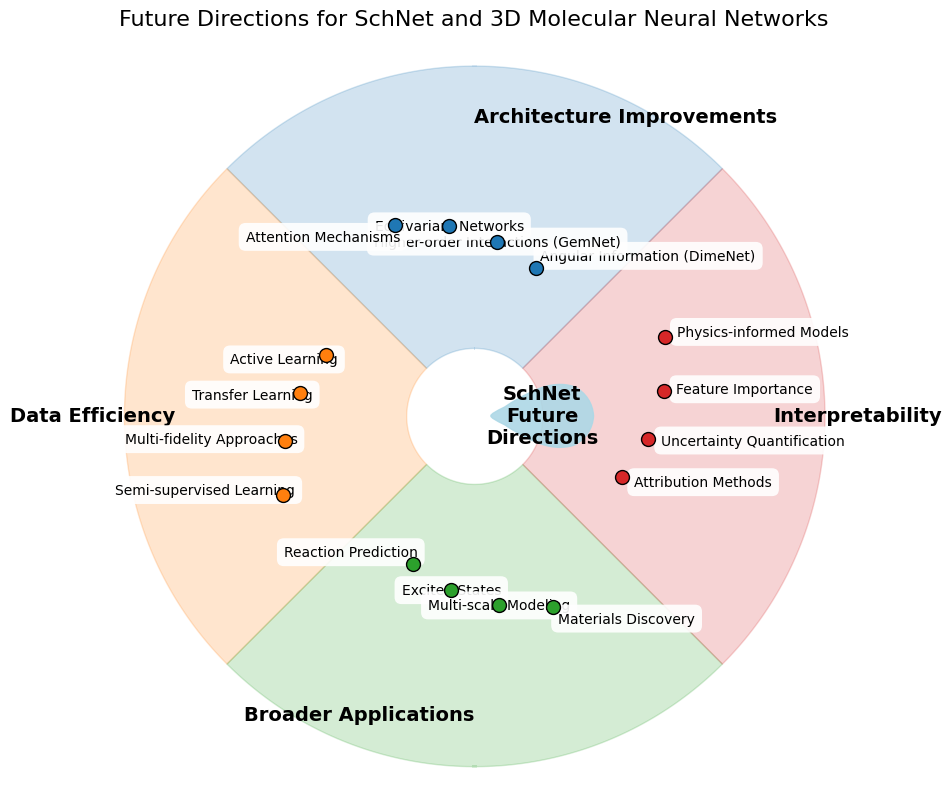

In [19]:
# Create a visualization of future directions for SchNet
def plot_future_directions():
    # Create a figure
    plt.figure(figsize=(12, 8))

    # Define main areas and specific directions
    areas = [
        'Architecture Improvements',
        'Data Efficiency', 
        'Broader Applications',
        'Interpretability'
    ]

    specific_directions = {
        'Architecture Improvements': [
            'Angular Information (DimeNet)',
            'Higher-order Interactions (GemNet)', 
            'Equivariant Networks',
            'Attention Mechanisms'
        ],
        'Data Efficiency': [
            'Active Learning',
            'Transfer Learning',
            'Multi-fidelity Approaches', 
            'Semi-supervised Learning'
        ],
        'Broader Applications': [
            'Reaction Prediction',
            'Excited States',
            'Multi-scale Modeling',
            'Materials Discovery'
        ],
        'Interpretability': [
            'Attribution Methods',
            'Uncertainty Quantification',
            'Feature Importance',
            'Physics-informed Models'
        ]
    }

    # Calculate positions
    n_areas = len(areas)
    angles = np.linspace(0, 2*np.pi, n_areas, endpoint=False)
    angles = angles + np.pi/2  # Start from top

    # Plot the areas
    ax = plt.subplot(111, polar=True)

    # Plot the circular segments for main areas
    for i, area in enumerate(areas):
        start_angle = angles[i] - np.pi/n_areas
        end_angle = angles[i] + np.pi/n_areas

        # Create a colored segment
        theta = np.linspace(start_angle, end_angle, 100)
        radii = np.ones_like(theta) * 2.2  # Increased radius

        # Plot the segment with transparency
        ax.fill_between(theta, 0, radii, alpha=0.2, color=f"C{i}")

        # Add the area label
        angle = angles[i]
        x = 1.8 * np.cos(angle)  # Increased distance
        y = 1.8 * np.sin(angle)
        ha = 'center'
        if np.cos(angle) < 0:
            ha = 'right'
        elif np.cos(angle) > 0:
            ha = 'left'
        plt.text(angle, 1.8, area, ha=ha, va='center', fontsize=14, fontweight='bold')

        # Add specific directions with more spacing
        for j, direction in enumerate(specific_directions[area]):
            # Calculate position with wider spacing
            inner_radius = 0.6
            radius = inner_radius + (1.2 - inner_radius) * ((j + 1) / (len(specific_directions[area]) + 1))
            
            # Wider angle spread
            dir_angle = angle - np.pi/8 + (j * np.pi/4) / (len(specific_directions[area]) - 1)

            # Add a point
            ax.scatter(dir_angle, radius, s=100, color=f"C{i}", edgecolor='black', zorder=10)

            # Add the direction label with adjusted position and background
            text_radius = radius
            ha = 'center'
            if np.cos(dir_angle) < -0.3:
                ha = 'right'
                text_radius = radius - 0.1
            elif np.cos(dir_angle) > 0.3:
                ha = 'left'
                text_radius = radius + 0.1
            
            plt.text(dir_angle, text_radius, direction, 
                    ha=ha, va='center', 
                    fontsize=10,
                    bbox=dict(facecolor='white', 
                             alpha=0.9, 
                             boxstyle='round,pad=0.5',
                             edgecolor='none'))

    # Add SchNet in the center
    circle = plt.Circle((0, 0), 0.4, color='lightblue', alpha=0.9)
    ax.add_patch(circle)
    plt.text(0, 0, 'SchNet\nFuture\nDirections', 
             ha='center', va='center', 
             fontsize=14, fontweight='bold')

    # Remove unnecessary elements
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(False)

    # Set plot limits to prevent cutoff
    ax.set_rmax(2.3)

    plt.title('Future Directions for SchNet and 3D Molecular Neural Networks', 
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Visualize future directions
plot_future_directions()

## 8. Conclusion <a name="conclusion"></a>

In this tutorial, we've explored SchNet, a pioneering deep learning architecture for 3D molecular modeling. Let's summarize what we've learned:

### Key Takeaways

1. **3D Information is Critical**: Unlike traditional GNNs, SchNet incorporates 3D atomic coordinates, enabling more accurate predictions of quantum-mechanical properties.

2. **Continuous-Filter Convolutions**: SchNet uses continuous-filter convolutions to operate on arbitrary atom positions, generalizing CNNs to molecular data.

3. **Physics-Informed Design**: By respecting physical symmetries (rotational, translational, and permutation invariance), SchNet makes predictions that follow fundamental physical laws.

4. **End-to-End Learning**: SchNet learns directly from atomic positions and types, without requiring predefined molecular descriptors or fingerprints.

5. **Interpretability**: The model enables visualization of atomic contributions (local chemical potentials), providing insights into how different parts of a molecule contribute to its properties.

### Practical Implications

SchNet and similar 3D-aware neural networks have several practical implications for chemistry and materials science:

- **Accelerating Quantum Chemistry**: Predictions in milliseconds that would take hours or days with traditional DFT calculations
- **Exploring Chemical Space**: Efficiently screening millions of candidate molecules for desired properties
- **Accurate Force Fields**: Creating ML-based force fields that approach quantum accuracy at classical computational cost
- **Structure-Property Relationships**: Gaining new insights into how 3D structure influences molecular properties

### Getting Started with SchNet

If you're interested in applying SchNet to your own research, here are some resources to get started:

- **SchNetPack**: The official implementation of SchNet - https://github.com/atomistic-machine-learning/schnetpack
- **QM9 Dataset**: A standard benchmark dataset for molecular property prediction - https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904
- **PyTorch Geometric**: Offers implementations of various GNNs including SchNet - https://pytorch-geometric.readthedocs.io/

### Final Thoughts

SchNet represents an important paradigm shift in molecular modeling, demonstrating how deep learning can complement and potentially transform quantum chemistry. It bridges the gap between data-driven approaches and physical understanding, paving the way for more accurate, efficient, and insightful molecular modeling.

As the field continues to advance, we can expect 3D-aware neural networks to play an increasingly important role in drug discovery, materials design, and fundamental chemical research.